In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
USER = %env USER

## **Scripts**

### import 

In [2]:
import numpy as np
import os
import gc
import healpy as hp
import h5py

import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u

from fpipe.pipeline.pipeline import run_pipeline
from fpipe.timestream import data_format
from fpipe.timestream.data_base import DATA_BASE as DB
from fpipe.timestream import freq_rebin
from fpipe.sim import nvss_sim
from fpipe.check import flux_tod as cft
from fpipe.check import flux_map as cfm
from fpipe.map import algebra as al

from fpipe.map import dirtymap_hp, cleanmap
from fpipe.plot import plot_map

/home/ycli/code/fpipe/fpipe/check/tsys.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### TOD simulation 

In [3]:
@run_pipeline
def sim_nvss_tod():
    
    data_base = '/home/ycli/data/fanalysis/'
    
    pipe_tasks = []
    pipe_outdir = data_base
    pipe_logging = 'info'
    pipe_copy = False
    pipe_feedback = 0
    pipe_timing = True

    pipe_tasks.append(nvss_sim.SimNVSS)
    
    simnvss_input_files = []
    simnvss_output_files = []
    simnvss_freq_select = (4096, 5734)
    
    
    return locals()

@run_pipeline
def rebin_frequency():
    
    data_base = '/home/ycli/data/fanalysis/'
    pipe_tasks = []
    pipe_outdir = data_base
    pipe_logging = 'info'
    pipe_copy = False
    pipe_feedback = 0
    pipe_timing = True
    
    feed_select = list(np.arange(1, 20))
    
    pipe_tasks.append(freq_rebin.Rebin)
    
    rb_input_files = [] #sir_output_files
    rb_corr = 'auto'
    rb_process_timing = True
    rb_output_files = [] #[ 'rb4_sumfeeds_nocal/%s'%(f, ) for f in input_files ]
    rb_bin_combine_number = None
    rb_freq_select = (0, None) #(4096, 5734)
    rb_bin_number = 1
    
    return locals()


@run_pipeline
def make_dirtymap():
    
    data_base = '/home/ycli/data/fanalysis/'
    
    pipe_tasks = []
    pipe_outdir = data_base
    pipe_logging = 'info'
    pipe_copy = False
    pipe_feedback = 0
    pipe_timing = True

    pipe_tasks.append(dirtymap_hp.DirtyMap_healpix)
    #pipe_tasks.append(cleanmap.CleanMap)
    
    dmh_input_files  = [] #['rmbsl_sumfeeds_CC/%s'%f for f in input_files]
    dmh_output_files = [] #['%s/dm_%02d_%s_%s%s'%(map_prefix, map_id, DATA, DATE, suffix), ]
    dmh_nside = 4096
    dmh_feed_select = None #feed_select
    dmh_ra_range = None #[ra_st, ra_ed]
    dmh_dec_range = None #[25.5, 27.5]
    #dmh_freq_select = (4096, 4098) #(4096, 5734)
    dmh_diag_cov = True
    dmh_center_only = False
    dmh_beam_fwhm_at21cm = 3./60.
    dmh_noise_weight = False
    dmh_use_mask = True
    
    cm_input_files  = [] #['%s/dm_%02d_%s_%s%s_vis.h5'%(map_prefix, map_id, DATA, DATE, suffix), ]
    cm_output_files = [] #['%s/cm_%02d_%s_%s%s_vis.h5'%(map_prefix, map_id, DATA, DATE, suffix), ]
    cm_healpix = True
    cm_diag_cov = False
    cm_threshold = 2.e-2
    
    return locals()

@run_pipeline
def make_cleanmap():

    data_base = '/home/DATA/ycli/fanalysis/'

    pipe_tasks = []
    pipe_outdir = data_base
    pipe_logging = 'info' #'debug' #'info'
    pipe_copy = False
    pipe_feedback = 0
    pipe_timing = True
    
    pipe_tasks.append(cleanmap.CleanMap)
    
    cm_input_files = [] #input_maps
    cm_output_files  = [] #['%s/cm_%02d_Combined%s_vis.h5'%(map_prefix, map_id, suffix), ]
    cm_healpix = True
    cm_threshold = 0 #1.e-2
    
    return locals()

## **Check TOD Flux**

### load source tod

In [20]:
map_info = None
nvss_map_info = None

nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]

flux_key = 'NVSS_FLUX'
name_key = 'NVSS_ID'

file_root = '/home/DATA/ycli/fanalysis/rmbsl_sumfeeds_CC_df50M/'
file_name_list = [
    #'20220210/HIMGS_1100+2600',
    '20210302/HIMGS_1100+2600',
    '20210314/HIMGS_1100+2610',
    '20210305/HIMGS_1100+2632',
    #'20210306/HIMGS_1100+2643',
    '20210307/HIMGS_1100+2654',
    '20210309/HIMGS_1100+2610',
    '20210313/HIMGS_1100+2621',
]
iso_threshold = 9.
flux_lim = 14. #20.
max_major_axis = 10.
max_dist = 1.5

#output_path = '/scratch3/users/ycli/fanalysis/nvss_tod_iso%d/'%iso_threshold
output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M/'%(iso_threshold, flux_lim)
#output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M_md%2.1f/'%(iso_threshold, 
#                                                                                      flux_lim,
#                                                                                      max_dist)


nvss_range = [[9*15+0.5, 13*15-0.5, 25.83, 27.08],]
#nvss_range = None

name_list = cft.output_source(file_root, file_name_list, output_path, nvss_path, 
                 flux_key=flux_key, name_key=name_key, max_major_axis=max_major_axis,
                 iso_threshold=iso_threshold, flux_lim = flux_lim,
                 fmin=1700, fmax=3200, debug=False, max_dist=max_dist,
                 nvss_range = nvss_range)

Frequency range 1400.00 - 1400.00 MHz
2798 of 6938 sources left with redundancy removing
176 of 2798 sources left with threshold cut 9.000000 arcmin
90 of 176 sources left with flux lim cut 14.000000 mJy
20210302_HIMGS_1100+2600
Beam 01 707831 [ 141.50223   25.99814] TOD:  70.21647 +-    0.00000
Beam 01 820944 [ 164.34647   26.02505] TOD:  98.33604 +-    0.00000
Beam 02 707831 [ 141.50223   25.99814] TOD:  79.13144 +-    0.00000
Beam 02 736332 [ 147.27684   26.03270] TOD:  22.58264 +-    0.00000
Beam 02 820944 [ 164.34647   26.02505] TOD: 157.93938 +-    0.00000
Beam 02 969964 [ 194.30219   26.02795] TOD:  50.29270 +-    0.00000
Beam 03 678930 [ 135.72793   25.92912] TOD:  22.67129 +-    0.00000
Beam 03 696348 [ 139.19744   25.90446] TOD:  56.78575 +-    0.00000
Beam 03 711495 [ 142.22171   25.91053] TOD:  57.64959 +-    0.00000
Beam 03 716894 [ 143.31532   25.91686] TOD:  54.63044 +-    0.00000
Beam 03 730807 [ 146.17640   25.91210] TOD: 685.25706 +-    0.00000
Beam 03 732291 [ 146.47

### check tod rms

Feed 01: rms 3.809417 (0.041843) N = 19

Average : rms 3.809417 (0.041843) 

Totally there are   19 (  16) sources

Feed 02: rms 4.312996 (0.042456) N = 24
Feed 03: rms 2.828132 (0.070309) N = 17
Feed 04: rms 4.654800 (0.075063) N = 23
Feed 05: rms 4.958152 (0.051431) N =  9
Feed 06: rms 5.635903 (0.049004) N = 15
Feed 07: rms 5.198721 (0.067061) N = 18

Average : rms 4.738866 (0.052519) 

Totally there are  106 (  58) sources

Feed 08: rms 6.093061 (0.059413) N = 18
Feed 09: rms 6.719136 (0.069168) N = 12
Feed 10: rms 11.466601 (0.085741) N =  5
Feed 11: rms 2.677743 (0.021745) N = 19
Feed 12: rms 3.336365 (0.116800) N =  8
Feed 13: rms 4.333457 (0.042588) N = 20
Feed 14: rms 4.579684 (0.064127) N = 19
Feed 15: rms 4.392905 (0.044919) N = 23
Feed 16: rms 5.224333 (0.091888) N = 15
Feed 17: rms 3.023038 (0.096141) N = 10
Feed 18: rms 5.594056 (0.092722) N = 23
Feed 19: rms 2.011006 (0.063654) N = 10

Average : rms 4.392632 (0.068717) 

Totally there are  182 (  77) sources

20210314 HI

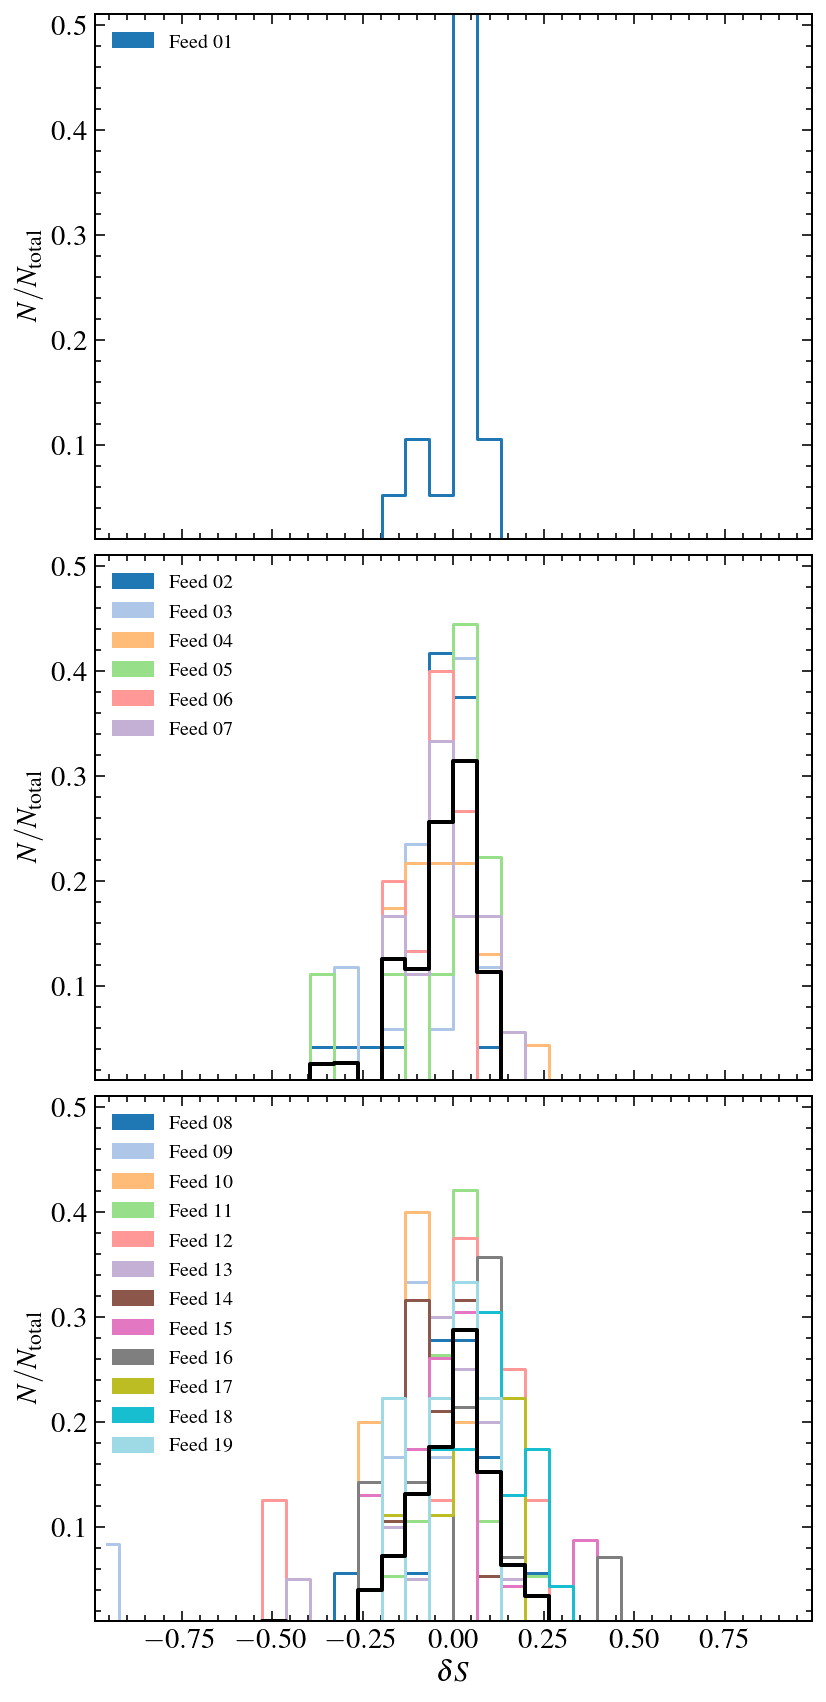

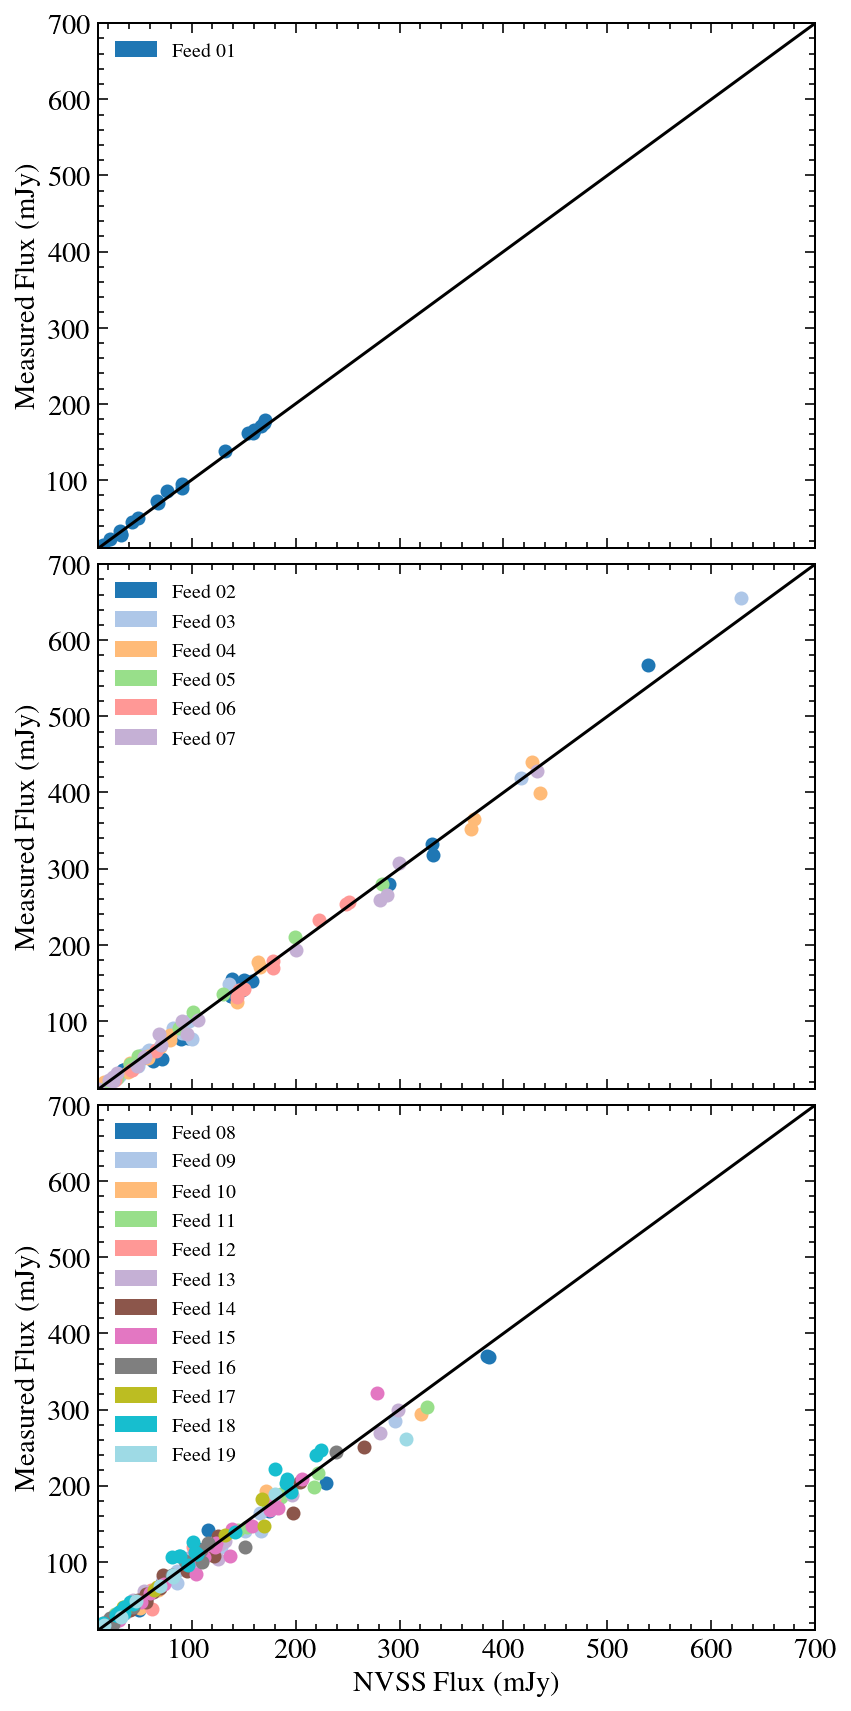

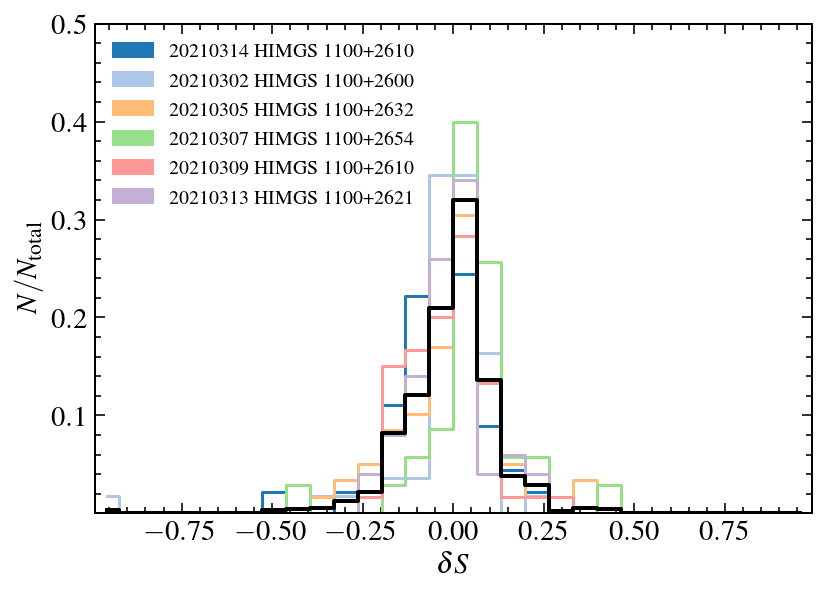

In [30]:
iso_threshold = 9.
flux_lim = 14.
max_dist = 0.5
output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M/'%(iso_threshold, flux_lim)
#output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M_md%2.1f/'%(iso_threshold, 
#                                                                                      flux_lim,
#                                                                                      max_dist)

flux_path_list = [
    output_path + '20210314_HIMGS_1100+2610.h5',
    output_path + '20210302_HIMGS_1100+2600.h5',
    #output_path + '20220210_HIMGS_1100+2600.h5',
    output_path + '20210305_HIMGS_1100+2632.h5',
    #output_path + '20210306_HIMGS_1100+2643.h5',
    output_path + '20210307_HIMGS_1100+2654.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',
    output_path + '20210313_HIMGS_1100+2621.h5',
]
beam_list = np.arange(19) + 1

fig = cft.plot_fluxfraction_hist_allbeam(flux_path_list, tod=True,  rms_sys=None, ymin=0.01, ymax=0.51)
fig.savefig('./plot/fluxfrachist_beam_tod_iso%d.png'%iso_threshold, dpi=200)
#print("="*60)

fig = cft.plot_flux_allbeam(flux_path_list, tod=True,  rms_sys=None, f_min=10, f_max=700)
fig.savefig('./plot/fluxflux_beam_tod_iso%d.png'%iso_threshold, dpi=200)

fig = cft.plot_flux_hist_alldays(flux_path_list, tod=True, rms_sys=None, ymin=1.e-4, ymax=0.50)

### residual as function of RA

Totally there are  363 ( 105) sources
Totally there are   22 (  19) sources
Totally there are  121 (  66) sources
Totally there are  220 ( 102) sources


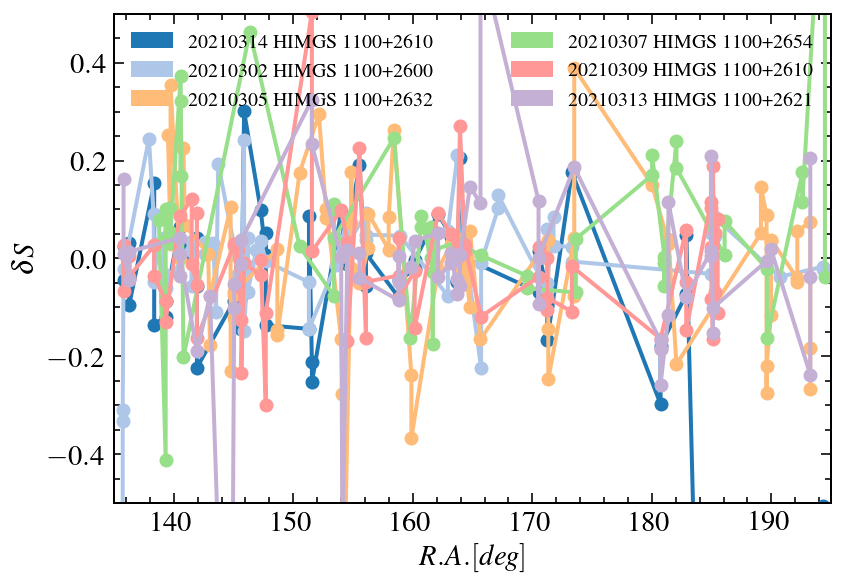

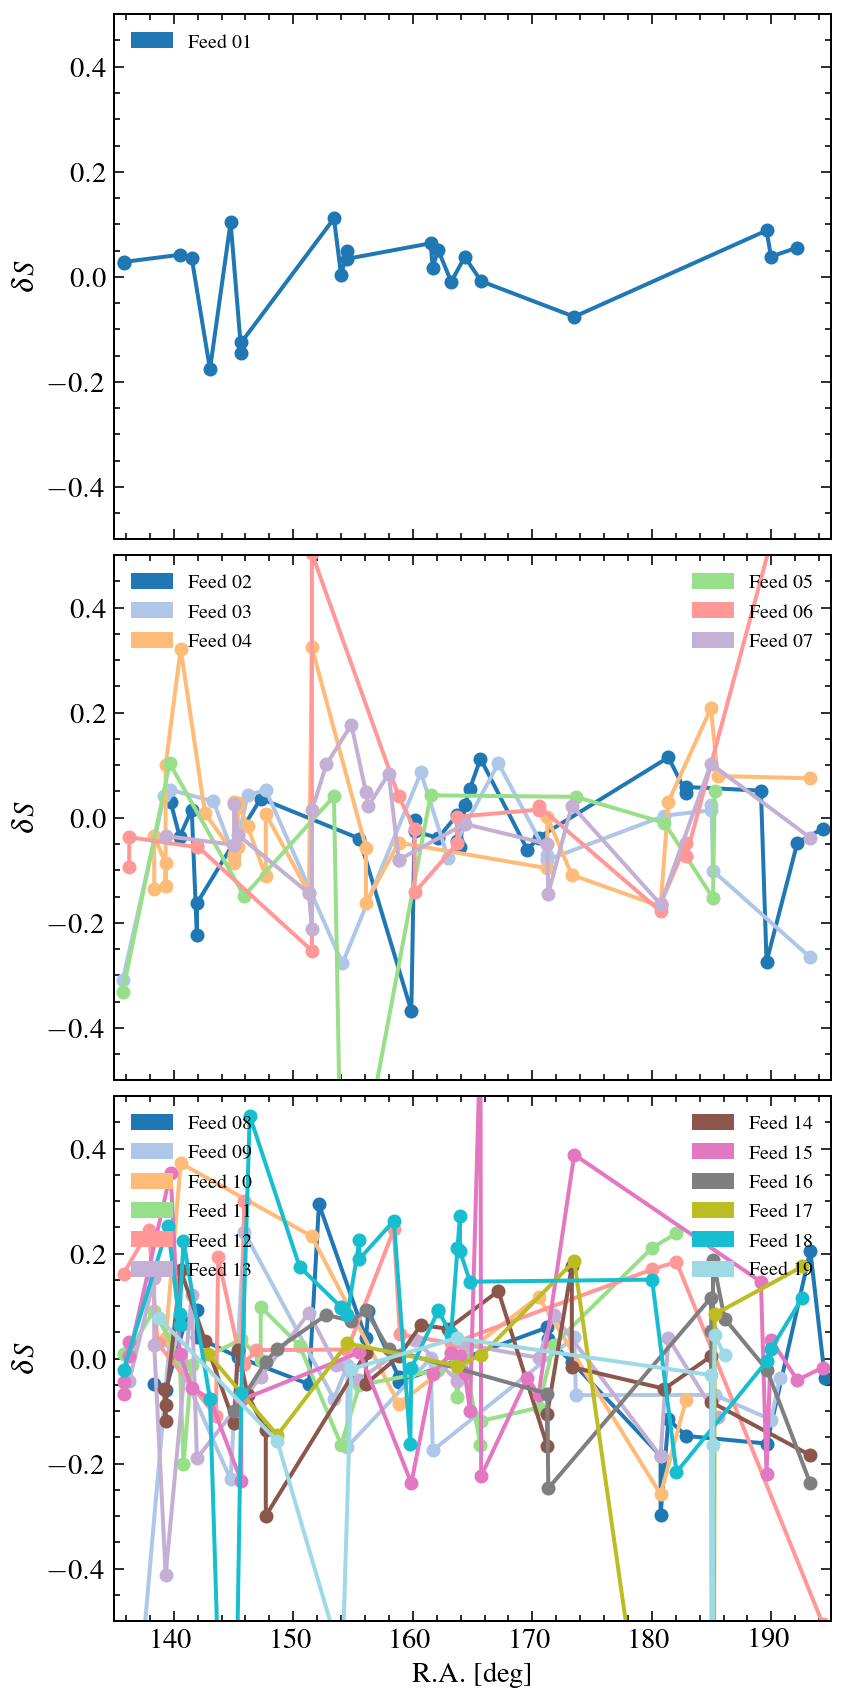

In [77]:
fig = cft.plot_flux_ra_alldays(flux_path_list, tod=True, rms_sys=None, ymin=-0.5, ymax=0.50)
fig = cft.plot_flux_ra_beams(flux_path_list, tod=True, rms_sys=None, ymin=-0.5, ymax=0.50)

### residual of the same field in two days 

20210309 HIMGS 1100+2610: rms 2.596549 (0.051788) N =101

Average : rms 2.596549 (0.051788) 

Totally there are  101 (  30) sources

20210309 HIMGS 1100+2610: rms 2.596549 (0.051788) N =101

Average : rms 2.596549 (0.051788) 

Totally there are  101 (  30) sources



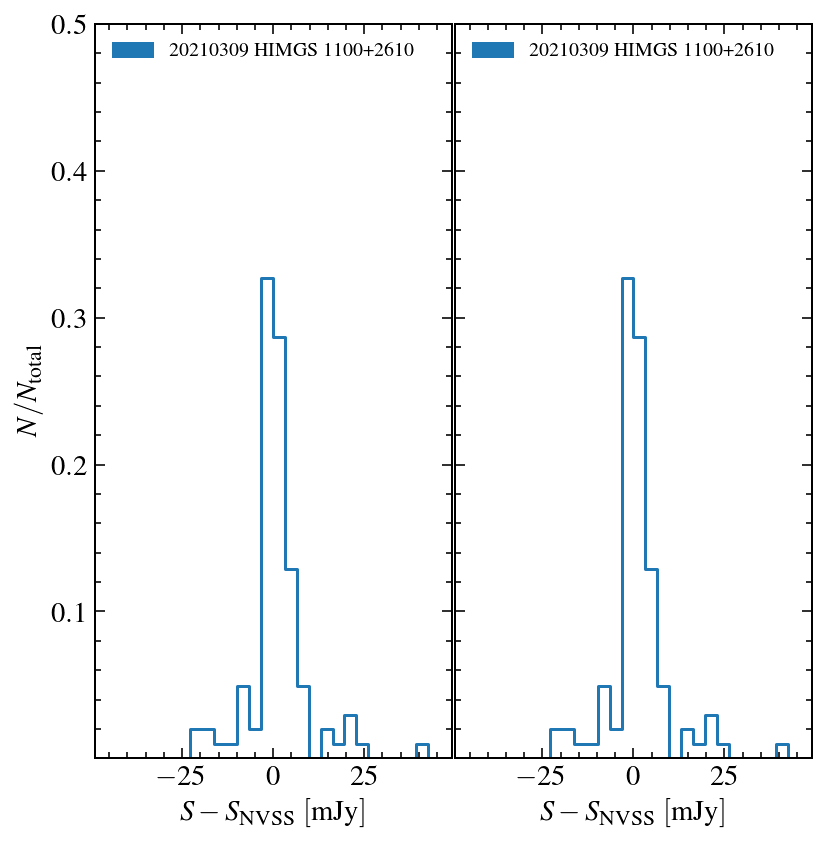

In [32]:
iso_threshold = 9.
flux_lim = 7.
output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M/'%(iso_threshold, flux_lim)

flux_path_list2 = [
    output_path + '20210314_HIMGS_1100+2610.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',

    output_path + '20210314_HIMGS_1100+2610.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',    
]

fig = cft.plot_flux_hist_day_vs_days(flux_path_list2, tod=True, rms_sys=None, ymin=1.e-4, ymax=0.5)

## **Simulate TOD**

In [4]:
DATA_list = ['20210302', '20210305', '20210306', '20210307', 
             '20210309', '20210313', '20210314' ]

suffix     = '_1250-1450MHz'

nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]

### simulate nvss tod

In [5]:
for DATA_Key in DATA_list[-1:]:
    
    DATA     = DB[DATA_Key]['DATA'    ]
    DATE     = DB[DATA_Key]['DATE'    ]
    bad_feed = DB[DATA_Key]['BAD_FEED']
    
    for file_st in range(1, 8)[-1:]:

        file_temp = '%s/%s_arcdrift%04d-%04d%s.h5'
        #file_st = 1
        file_ed = file_st
        input_files = []

        for i in range(file_st, file_ed + 1):
            input_files.append(file_temp%(DATE, DATA, i, i, suffix))
        
        sim_nvss_tod['simnvss_input_files']  = ['rmbsl_sumfeeds_CC/%s'%f for f in input_files]
        sim_nvss_tod['simnvss_output_files'] = ['sim_nvsstod/%s'%f for f in input_files]
        sim_nvss_tod['simnvss_nvss_cat_list'] = nvss_path
        
        # for 20210314/HIMGS_1100+2610_arcdrift0007-0007_1250-1450MHz.h5
        # need to cut off the beginning part
        sim_nvss_tod['simnvss_nvss_range'] = [190, 13*15+0.5, 25.5, 27.0] 
        sim_nvss_tod()

INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.sim.nvss_sim.SimNVSS'>
INFO:tlpipe.pipeline.pipeline:SimNVSS reading data from files:
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.sim.nvss_sim:simulate tod using nvss catalogue
INFO:fpipe.sim.nvss_sim:Sim Tod for B00,  298 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B01,  318 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B02,  296 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B03,  281 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B04,  288 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B05,  307 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B06,  320 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B07,  333 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B08,  308 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B09,  289 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B10,  273 sources used
INFO:fpipe.sim.nvss_sim:Sim Tod for B11,



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



### rebin simulated tod into single frequency

In [33]:
for DATA_Key in DATA_list[-1:]:
    
    DATA     = DB[DATA_Key]['DATA'    ]
    DATE     = DB[DATA_Key]['DATE'    ]
    bad_feed = DB[DATA_Key]['BAD_FEED']

    file_temp = '%s/%s_arcdrift%04d-%04d%s.h5'
    file_st = 1
    file_ed = file_st + 6
    input_files = []

    for i in range(file_st, file_ed + 1):
        input_files.append(file_temp%(DATE, DATA, i, i, suffix))
        
    rebin_frequency['rb_input_files'] = ['sim_nvsstod/%s'%f for f in input_files]
    rebin_frequency['rb_output_files'] = ['sim_nvsstod_rebin/%s'%f for f in input_files]
    rebin_frequency()

INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-14 17:28:09.597269...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod/20210314/HIMGS_1100+2610_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sim_nvsstod/20210314/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sim_nvsstod/20210314/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sim_nvsstod/20210314/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sim_nvsstod/20210314/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sim_nvsstod/20210314/HIMGS_1100+2610_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/sim_nvsstod/20210314/HIMGS_1100+2610_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.timestream.freq_rebin:freq resolution reduced from 0.030517578 to 4



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



### rebin observation tod into single frequency 

In [9]:
for DATA_Key in DATA_list:
    
    DATA     = DB[DATA_Key]['DATA'    ]
    DATE     = DB[DATA_Key]['DATE'    ]
    bad_feed = DB[DATA_Key]['BAD_FEED']

    file_temp = '%s/%s_arcdrift%04d-%04d%s.h5'
    file_st = 1
    file_ed = file_st + 6
    input_files = []

    for i in range(file_st, file_ed + 1):
        input_files.append(file_temp%(DATE, DATA, i, i, suffix))
        
    rebin_frequency['rb_input_files'] = ['rmbsl_sumfeeds_CC/%s'%f for f in input_files]
    rebin_frequency['rb_output_files'] = ['rmbsl_sumfeeds_CC_rebin/%s'%f for f in input_files]
    rebin_frequency['rb_freq_select'] = (4096, 5734)
    rebin_frequency()

INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210302/HIMGS_1100+2600_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210302/HIMGS_1100+2600_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210302/HIMGS_1100+2600_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210302/HIMGS_1100+2600_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210302/HIMGS_1100+2600_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210302/HIMGS_1100+2600_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210302/HIMGS_1100+2600_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.timestream.freq_rebin:freq resolution reduced from 0.030517578 to 49.989700 MHz (1638 - 1)
INFO:tlpipe.pipe



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-14 20:52:05.658645...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210305/HIMGS_1100+2632_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210305/HIMGS_1100+2632_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210305/HIMGS_1100+2632_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210305/HIMGS_1100+2632_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210305/HIMGS_1100+2632_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210305/HIMGS_1100+2632_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210305/HIMGS_1100+2632_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.timestream.freq_rebin:fre



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-14 20:56:01.187313...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210306/HIMGS_1100+2643_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210306/HIMGS_1100+2643_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210306/HIMGS_1100+2643_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210306/HIMGS_1100+2643_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210306/HIMGS_1100+2643_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210306/HIMGS_1100+2643_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210306/HIMGS_1100+2643_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.timestream.freq_rebin:fre



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-14 20:59:32.976708...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210307/HIMGS_1100+2654_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210307/HIMGS_1100+2654_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210307/HIMGS_1100+2654_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210307/HIMGS_1100+2654_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210307/HIMGS_1100+2654_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210307/HIMGS_1100+2654_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210307/HIMGS_1100+2654_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.timestream.freq_rebin:fre



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-14 21:04:19.053691...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210309/HIMGS_1100+2610_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210309/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210309/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210309/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210309/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210309/HIMGS_1100+2610_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210309/HIMGS_1100+2610_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.timestream.freq_rebin:fre



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-14 21:05:36.953846...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210313/HIMGS_1100+2621_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210313/HIMGS_1100+2621_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210313/HIMGS_1100+2621_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210313/HIMGS_1100+2621_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210313/HIMGS_1100+2621_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210313/HIMGS_1100+2621_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210313/HIMGS_1100+2621_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.timestream.freq_rebin:fre



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-14 21:06:51.753663...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.timestream.freq_rebin.Rebin'>
INFO:tlpipe.pipeline.pipeline:Rebin reading data from files:
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0001-0001_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0006-0006_1250-1450MHz.h5
	/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.timestream.freq_rebin:fre



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



### plot tod sim vs obs

In [ ]:
tod_path = '/home/ycli/data/fanalysis/sim_nvsstod_rebin/'
tod_file = '20210302/HIMGS_1100+2600_arcdrift0001-0001_1250-1450MHz.h5'
with h5py.File(tod_path + tod_file, 'r') as fp:
    
    vis = fp['vis'][:]
    msk = fp['vis_mask'][:].astype('bool')
    ra  = fp['ra'][:]
    
    ns_on = fp['ns_on'][:]
    #vis_sim = np.ma.array(vis, mask=msk)
    vis_sim = np.ma.array(vis, mask=False)
    #vis_sim.mask += ns_on[:, None, None, :]
    
    print(vis_sim.shape)
    
tod_path = '/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC_df50M/'
tod_file = '20210302/HIMGS_1100+2600_arcdrift0001-0001_1250-1450MHz.h5'
with h5py.File(tod_path + tod_file, 'r') as fp:
    
    vis = fp['vis'][:]
    msk = fp['vis_mask'][:].astype('bool')
    ra  = fp['ra'][:]
    
    ns_on = fp['ns_on'][:]
    vis_real = np.ma.array(vis, mask=msk)
    vis_real.mask += ns_on[:, None, None, :]
    
    print(vis_real.shape)

for bi in range(vis.shape[3]):
    fig = plt.figure(figsize=(10, 3))
    #plt.plot(ra[:, bi], np.mean(vis_real[:, :, :, bi], axis=(1,2)))
    #plt.plot(ra[:, bi], np.mean(vis_sim[:, :, :, bi],  axis=(1,2)))
    
    plt.plot(ra[:, bi], vis_real[:, 0, 0, bi])
    plt.plot(ra[:, bi], vis_real[:, 0, 1, bi])
    
    
    plt.plot(ra[:, bi], vis_sim[:, 0, 0, bi], 'k-')
    plt.plot(ra[:, bi], vis_sim[:, 0, 1, bi], 'r--')
    plt.show()

## **Make map using simulated TOD**

In [21]:
DATA_list = ['20210302', '20210305', '20210306', '20210307', 
             '20210309', '20210313', '20210314' ]

#map_id     = 0
suffix     = '_1250-1450MHz'
map_prefix = 'map_sim_nvsstod_df50M_NoMask_NoBadBeam'

for map_id in range(7):

    ra_list    = np.linspace(9, 13, 8)
    ra_st      = ra_list[map_id  ] * 15 - 0.5
    ra_ed      = ra_list[map_id+1] * 15 + 0.5
    
    for DATA_Key in DATA_list:
    
        DATA     = DB[DATA_Key]['DATA'    ]
        DATE     = DB[DATA_Key]['DATE'    ]
        bad_feed = DB[DATA_Key]['BAD_FEED']
    
        file_temp = '%s/%s_arcdrift%04d-%04d%s.h5'
        file_st = map_id + 1
        file_ed = file_st
        input_files = []
    
        for i in range(file_st, file_ed + 1):
            input_files.append(file_temp%(DATE, DATA, i, i, suffix))
        #print(input_files)
        feed_select = [*range(1, 20)]
        #for x in bad_feed:
        #    feed_select.remove(x)
    
        make_dirtymap['dmh_input_files']  = ['sim_nvsstod_rebin/%s'%f for f in input_files]
        make_dirtymap['dmh_output_files'] = ['%s/dm_%02d_%s_%s%s'%(map_prefix, map_id, 
                                                                   DATA, DATE, suffix), ]
        make_dirtymap['dmh_feed_select']  = feed_select
        make_dirtymap['dmh_ra_range']     = [ra_st, ra_ed]
        make_dirtymap['dmh_dec_range']    = [25.5, 27.5]
        make_dirtymap['dmh_use_mask']     = False
        make_dirtymap()


INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:25:49.728299...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210302/HIMGS_1100+2600_arcdrift0001-0001_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:28:58.300835...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210305/HIMGS_1100+2632_arcdrift0001-0001_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:32:07.433559...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210306/HIMGS_1100+2643_arcdrift0001-0001_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:35:16.692350...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210307/HIMGS_1100+2654_arcdrift0001-0001_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:41:14.270681...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210313/HIMGS_1100+2621_arcdrift0001-0001_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:44:22.539126...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210314/HIMGS_1100+2610_arcdrift0001-0001_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:47:30.732755...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210302/HIMGS_1100+2600_arcdrift0002-0002_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:50:38.825641...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210305/HIMGS_1100+2632_arcdrift0002-0002_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:53:47.179465...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210306/HIMGS_1100+2643_arcdrift0002-0002_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 00:56:55.908808...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210307/HIMGS_1100+2654_arcdrift0002-0002_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:00:04.170583...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210309/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:02:43.623719...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210313/HIMGS_1100+2621_arcdrift0002-0002_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:05:52.065626...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210314/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:09:00.417143...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210302/HIMGS_1100+2600_arcdrift0003-0003_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:12:08.756697...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210305/HIMGS_1100+2632_arcdrift0003-0003_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:15:17.433525...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210306/HIMGS_1100+2643_arcdrift0003-0003_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:18:25.868637...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210307/HIMGS_1100+2654_arcdrift0003-0003_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:21:34.249412...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210309/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:23:55.538083...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210313/HIMGS_1100+2621_arcdrift0003-0003_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:27:03.971771...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210314/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:30:12.240933...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210302/HIMGS_1100+2600_arcdrift0004-0004_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:33:20.307838...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210305/HIMGS_1100+2632_arcdrift0004-0004_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:36:28.671022...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210306/HIMGS_1100+2643_arcdrift0004-0004_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:39:37.051201...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210307/HIMGS_1100+2654_arcdrift0004-0004_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:42:45.292835...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210309/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:44:48.154328...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210313/HIMGS_1100+2621_arcdrift0004-0004_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:47:56.566132...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210314/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:51:04.807273...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210302/HIMGS_1100+2600_arcdrift0005-0005_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:54:12.782586...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210305/HIMGS_1100+2632_arcdrift0005-0005_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 01:57:21.051690...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210306/HIMGS_1100+2643_arcdrift0005-0005_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:00:29.243842...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210307/HIMGS_1100+2654_arcdrift0005-0005_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:03:37.380290...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210309/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:05:21.902484...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210313/HIMGS_1100+2621_arcdrift0005-0005_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:08:30.138792...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210314/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:11:38.214786...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210302/HIMGS_1100+2600_arcdrift0006-0006_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:14:46.244362...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210305/HIMGS_1100+2632_arcdrift0006-0006_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:17:54.411940...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210306/HIMGS_1100+2643_arcdrift0006-0006_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:21:02.468353...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210307/HIMGS_1100+2654_arcdrift0006-0006_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:24:10.497790...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210309/HIMGS_1100+2610_arcdrift0006-0006_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:25:36.680017...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210313/HIMGS_1100+2621_arcdrift0006-0006_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:28:44.723266...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210314/HIMGS_1100+2610_arcdrift0006-0006_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:31:52.646836...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210302/HIMGS_1100+2600_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:35:00.498417...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210305/HIMGS_1100+2632_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:38:08.535529...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210306/HIMGS_1100+2643_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:41:16.465826...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210307/HIMGS_1100+2654_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:44:24.486398...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210309/HIMGS_1100+2610_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:45:32.291736...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210313/HIMGS_1100+2621_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 02:48:40.370824...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.dirtymap_hp.DirtyMap_healpix'>
INFO:tlpipe.pipeline.pipeline:DirtyMap_healpix reading data from files:
	/home/ycli/data/fanalysis/sim_nvsstod_rebin/20210314/HIMGS_1100+2610_arcdrift0007-0007_1250-1450MHz.h5
INFO:fpipe.map.dirtymap:Ignore tod mask
INFO:fpipe.map.dirtymap_hp:RANK000: Local  (0000, ), Global (0000, ) at 1.4000GHz (fwhm = 0.051 deg)
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (000, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (001, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (002, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (003, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (004, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (005, 000, 000, ) Map (000, )
INFO:fpipe.map.dirtymap_hp:RANK000: VIS (006, 000, 000, ) Map (000, )
INFO:fpipe.ma



=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



In [22]:
suffix     = '_1250-1450MHz'
map_prefix = 'map_sim_nvsstod_df50M_NoMask_NoBadBeam'

DATA_list = [
    'HIMGS_1100+2600_20210302',
    'HIMGS_1100+2610_20210309',
    'HIMGS_1100+2610_20210314',
    'HIMGS_1100+2621_20210313',
    'HIMGS_1100+2632_20210305',
    #'HIMGS_1100+2643_20210306',
    'HIMGS_1100+2654_20210307',
]
for map_id in range(7):

    input_maps = []
    for f in DATA_list:
        input_maps.append( '%s/dm_%02d_%s%s_vis.h5'%(map_prefix, map_id, f, suffix))
    make_cleanmap['cm_input_files'] = input_maps
    make_cleanmap['cm_output_files']= ['%s/cm_%02d_Combined%s_vis.h5'%(map_prefix, map_id, suffix), ]
    make_cleanmap()

INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 17:56:29.477310...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.cleanmap.CleanMap'>
INFO:tlpipe.pipeline.pipeline:CleanMap reading data from files:
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_00_HIMGS_1100+2600_20210302_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_00_HIMGS_1100+2610_20210309_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_00_HIMGS_1100+2610_20210314_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_00_HIMGS_1100+2621_20210313_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_00_HIMGS_1100+2632_20210305_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_00_HIMGS_1100+2654_20210307_1250-1450MHz_vis.h5
INFO:fpipe.map.cleanmap:/home/DATA/ycli/fanalysis/map_sim_nvsstod

RANK000: (0000, )


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2023-01-23 17:56:29.955271...
INFO:tlpipe.pipeline.pipeline:Total run time: 0.48 seconds


Finishing CleanMapMaking.


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 17:56:29.957096...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.cleanmap.CleanMap'>
INFO:tlpipe.pipeline.pipeline:CleanMap reading data from files:
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_01_HIMGS_1100+2600_20210302_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_01_HIMGS_1100+2610_20210309_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_01_HIMGS_1100+2610_20210314_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_01_HIMGS_1100+2621_20210313_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_01_HIMGS_1100+2632_20210305_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_01_HIMGS_1100+2654_20210307_1250-1450MHz_vis.h5
INFO:fpipe.map.cleanmap:/home/DATA/ycli/fanalysis/map_sim_nvsstod

RANK000: (0000, )


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2023-01-23 17:56:30.303919...
INFO:tlpipe.pipeline.pipeline:Total run time: 0.35 seconds


Finishing CleanMapMaking.


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 17:56:30.306078...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.cleanmap.CleanMap'>
INFO:tlpipe.pipeline.pipeline:CleanMap reading data from files:
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_02_HIMGS_1100+2600_20210302_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_02_HIMGS_1100+2610_20210309_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_02_HIMGS_1100+2610_20210314_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_02_HIMGS_1100+2621_20210313_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_02_HIMGS_1100+2632_20210305_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_02_HIMGS_1100+2654_20210307_1250-1450MHz_vis.h5
INFO:fpipe.map.cleanmap:/home/DATA/ycli/fanalysis/map_sim_nvsstod

RANK000: (0000, )


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2023-01-23 17:56:30.779771...
INFO:tlpipe.pipeline.pipeline:Total run time: 0.47 seconds


Finishing CleanMapMaking.


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 17:56:30.781659...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.cleanmap.CleanMap'>
INFO:tlpipe.pipeline.pipeline:CleanMap reading data from files:
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_03_HIMGS_1100+2600_20210302_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_03_HIMGS_1100+2610_20210309_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_03_HIMGS_1100+2610_20210314_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_03_HIMGS_1100+2621_20210313_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_03_HIMGS_1100+2632_20210305_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_03_HIMGS_1100+2654_20210307_1250-1450MHz_vis.h5
INFO:fpipe.map.cleanmap:/home/DATA/ycli/fanalysis/map_sim_nvsstod

RANK000: (0000, )


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2023-01-23 17:56:31.177479...
INFO:tlpipe.pipeline.pipeline:Total run time: 0.40 seconds


Finishing CleanMapMaking.


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 17:56:31.179390...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.cleanmap.CleanMap'>
INFO:tlpipe.pipeline.pipeline:CleanMap reading data from files:
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_04_HIMGS_1100+2600_20210302_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_04_HIMGS_1100+2610_20210309_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_04_HIMGS_1100+2610_20210314_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_04_HIMGS_1100+2621_20210313_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_04_HIMGS_1100+2632_20210305_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_04_HIMGS_1100+2654_20210307_1250-1450MHz_vis.h5
INFO:fpipe.map.cleanmap:/home/DATA/ycli/fanalysis/map_sim_nvsstod

RANK000: (0000, )


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2023-01-23 17:56:31.597171...
INFO:tlpipe.pipeline.pipeline:Total run time: 0.42 seconds


Finishing CleanMapMaking.


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 17:56:31.599133...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.cleanmap.CleanMap'>
INFO:tlpipe.pipeline.pipeline:CleanMap reading data from files:
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_05_HIMGS_1100+2600_20210302_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_05_HIMGS_1100+2610_20210309_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_05_HIMGS_1100+2610_20210314_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_05_HIMGS_1100+2621_20210313_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_05_HIMGS_1100+2632_20210305_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_05_HIMGS_1100+2654_20210307_1250-1450MHz_vis.h5
INFO:fpipe.map.cleanmap:/home/DATA/ycli/fanalysis/map_sim_nvsstod

RANK000: (0000, )


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2023-01-23 17:56:32.330616...
INFO:tlpipe.pipeline.pipeline:Total run time: 0.73 seconds


Finishing CleanMapMaking.


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



INFO:tlpipe.pipeline.pipeline:Start the pipeline at 2023-01-23 17:56:32.332800...
INFO:tlpipe.pipeline.pipeline:Initializing task: <class 'fpipe.map.cleanmap.CleanMap'>
INFO:tlpipe.pipeline.pipeline:CleanMap reading data from files:
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_06_HIMGS_1100+2600_20210302_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_06_HIMGS_1100+2610_20210309_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_06_HIMGS_1100+2610_20210314_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_06_HIMGS_1100+2621_20210313_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_06_HIMGS_1100+2632_20210305_1250-1450MHz_vis.h5
	/home/DATA/ycli/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/dm_06_HIMGS_1100+2654_20210307_1250-1450MHz_vis.h5
INFO:fpipe.map.cleanmap:/home/DATA/ycli/fanalysis/map_sim_nvsstod

RANK000: (0000, )


INFO:tlpipe.pipeline.pipeline:End the pipeline at 2023-01-23 17:56:32.756335...
INFO:tlpipe.pipeline.pipeline:Total run time: 0.42 seconds


Finishing CleanMapMaking.


=                                        =
=        DONE FOR THE PIPELINE!!         =
=           CONGRATULATIONS!!            =
=                                        =



Load maps from /home/ycli/data/fanalysis/map_sim_nvsstod/cm_00_Combined_1250-1450MHz_vis.h5
['clean_map', 'dirty_map', 'map_pix', 'noise_diag', 'nside']


/home/ycli/code/fpipe/fpipe/map/algebra.py:1045: UserWarning: Initialization argument ignored. Requisite metadata for vector already exists. Clear info dictionary if you want opposite behaviour.
  warnings.warn("Initialization argument ignored. Requisite "


Load maps from /home/ycli/data/fanalysis/map_sim_nvsstod_peaknorm/cm_00_Combined_1250-1450MHz_vis.h5
['clean_map', 'dirty_map', 'map_pix', 'noise_diag', 'nside']
Load maps from /home/ycli/data/fanalysis/map_sim_nvsstod_rebin/cm_00_Combined_1250-1450MHz_vis.h5
['clean_map', 'dirty_map', 'map_pix', 'noise_diag', 'nside']


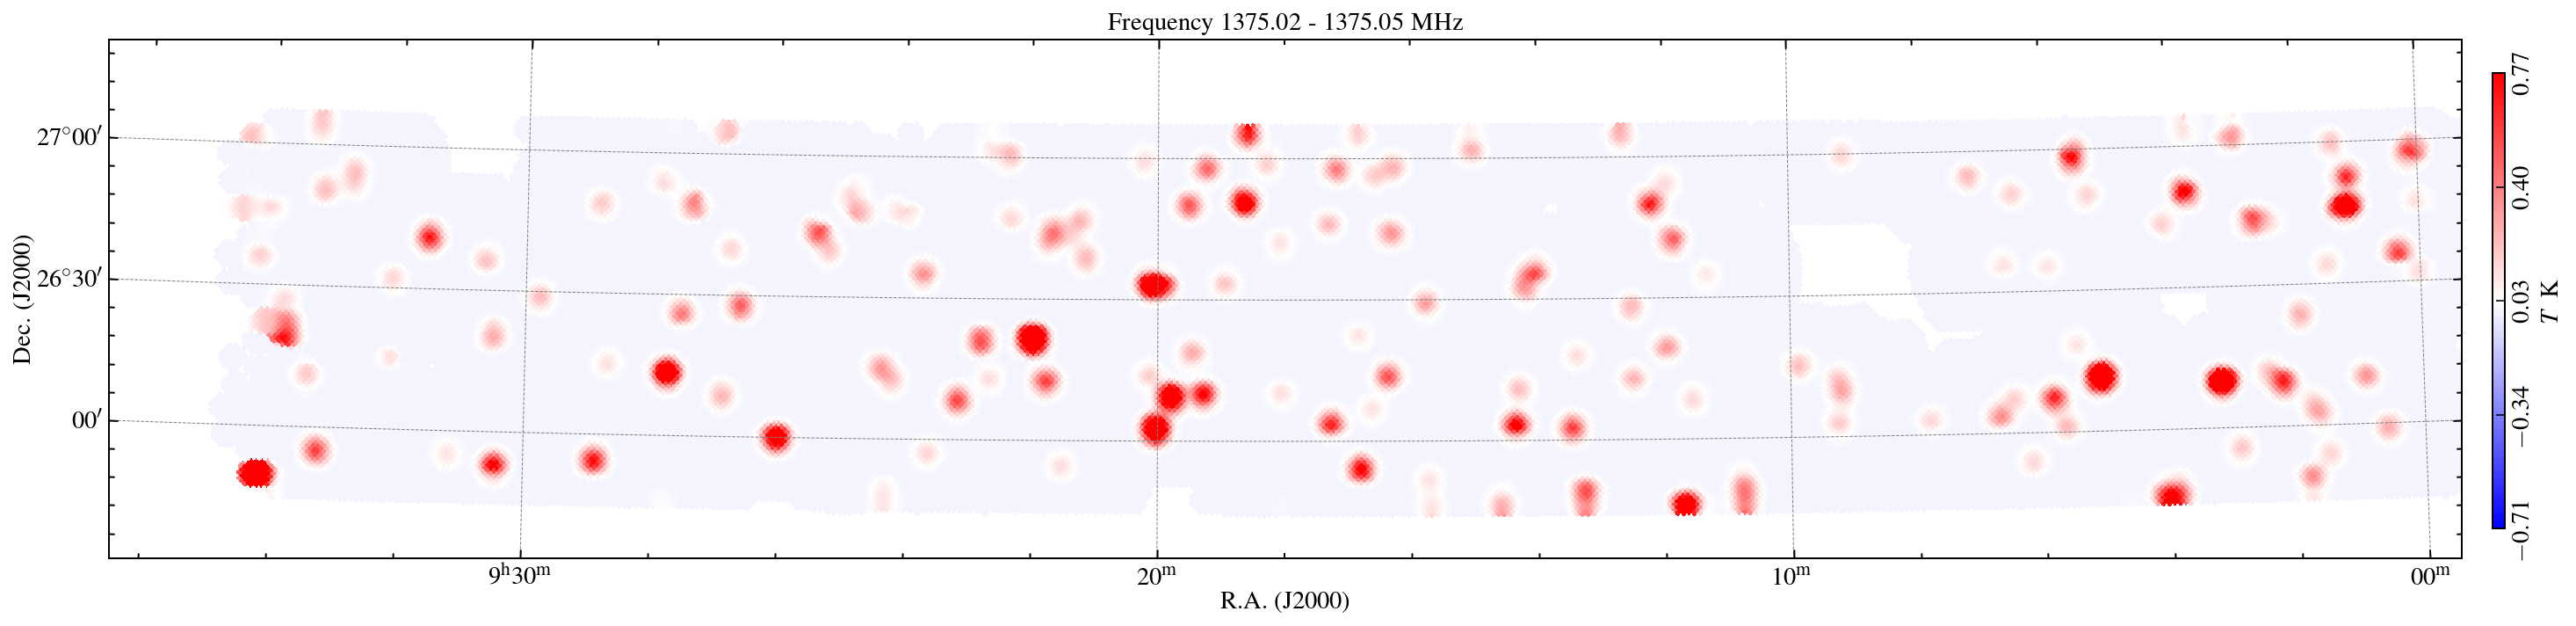

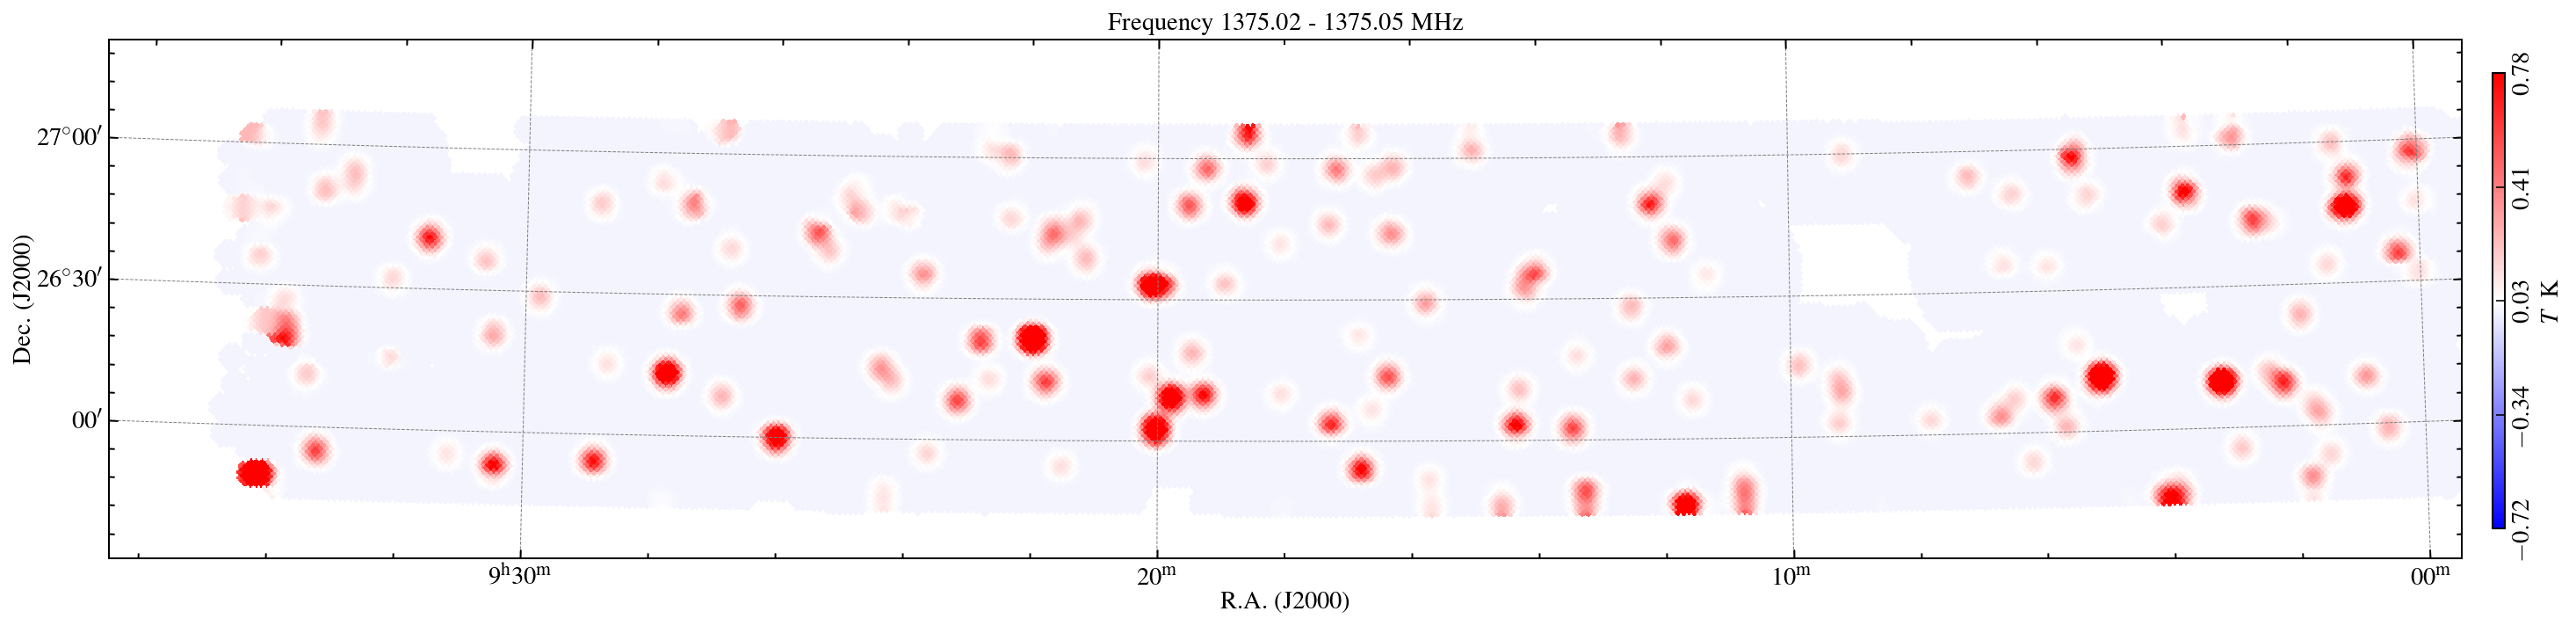

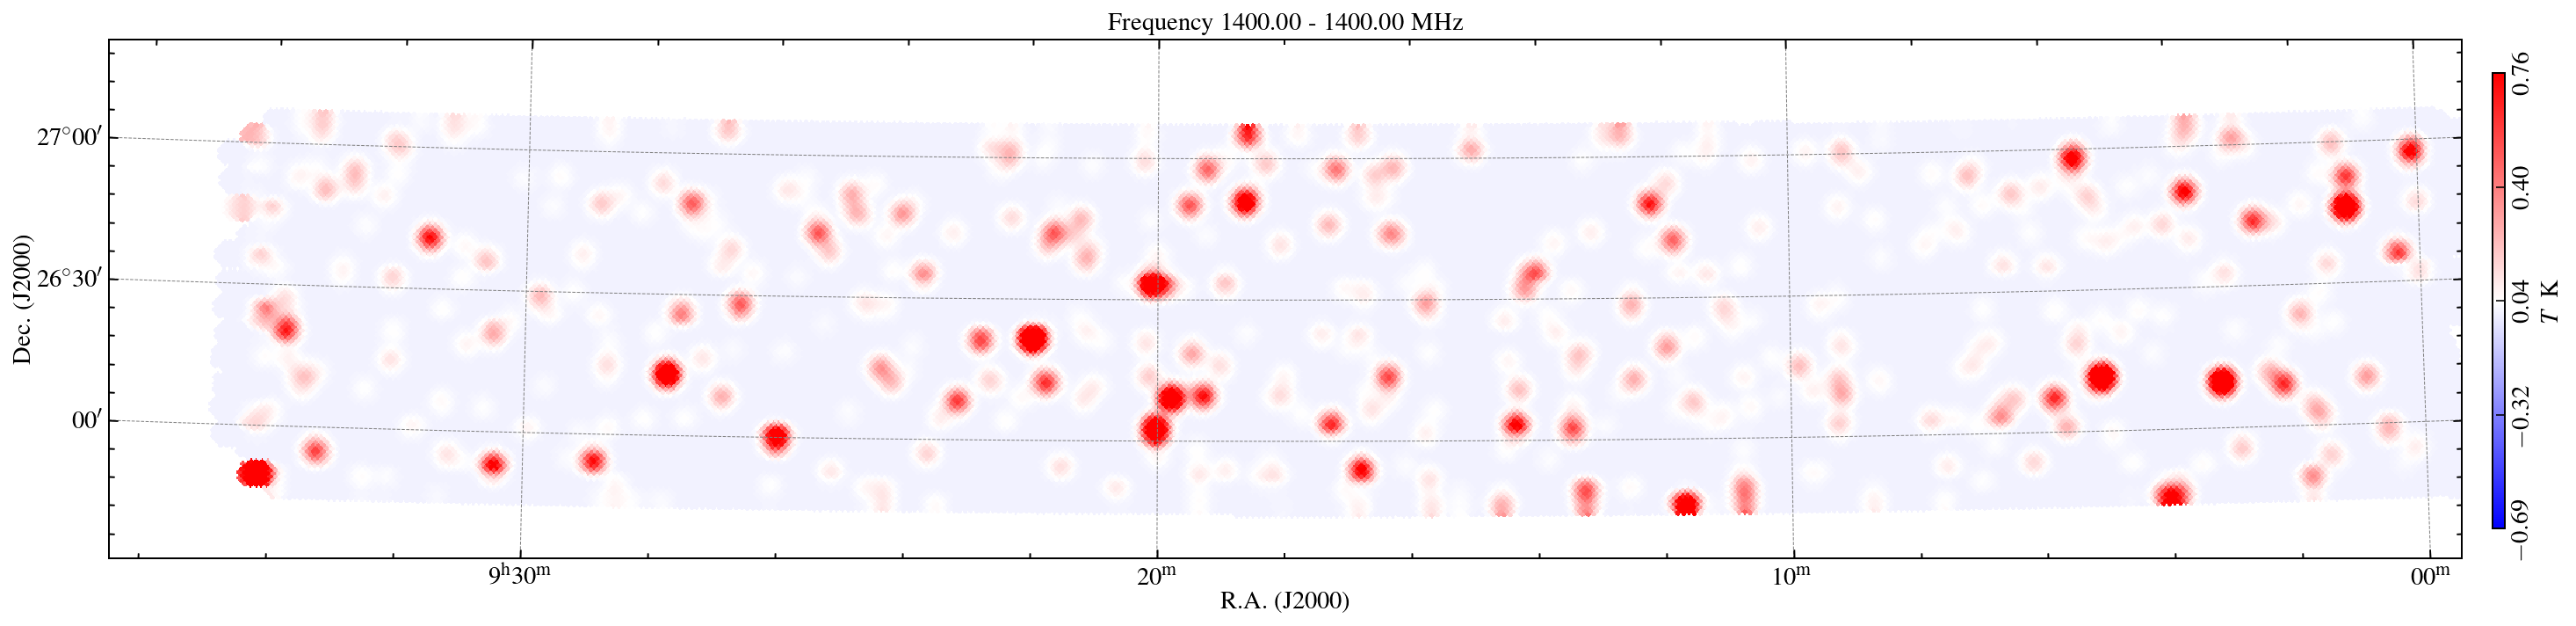

In [10]:
map_name = '/home/ycli/data/fanalysis/map_sim_nvsstod/cm_00_Combined_1250-1450MHz_vis.h5'
axes = None
nvss_path = None
indx = (slice(0, None), )
axes = plot_map.plot_map_hp(map_name, map_key='clean_map',
                         pix=0.25/60., indx=indx,
                         imap_shp = (2000, 440), axes=axes,
                         field_center=[(9.3*15, 26.5),  ],
                         figsize=(24, 6), sigma = 6,
                         title='', proj='ZEA', cmap='bwr', 
                         nvss_path=nvss_path)

map_name = '/home/ycli/data/fanalysis/map_sim_nvsstod_peaknorm/cm_00_Combined_1250-1450MHz_vis.h5'
axes = None
nvss_path = None
indx = (slice(0, None), )
axes = plot_map.plot_map_hp(map_name, map_key='clean_map',
                         pix=0.25/60., indx=indx,
                         imap_shp = (2000, 440), axes=axes,
                         field_center=[(9.3*15, 26.5),  ],
                         figsize=(24, 6), sigma = 6,
                         title='', proj='ZEA', cmap='bwr', 
                         nvss_path=nvss_path)

map_name = '/home/ycli/data/fanalysis/map_sim_nvsstod_rebin/cm_00_Combined_1250-1450MHz_vis.h5'
axes = None
nvss_path = None
indx = (slice(0, None), )
axes = plot_map.plot_map_hp(map_name, map_key='clean_map',
                         pix=0.25/60., indx=indx,
                         imap_shp = (2000, 440), axes=axes,
                         field_center=[(9.3*15, 26.5),  ],
                         figsize=(24, 6), sigma = 6,
                         title='', proj='ZEA', cmap='bwr', 
                         nvss_path=nvss_path)

Load maps from /home/ycli/data/fanalysis/map_df28k_2021_test_noNW/cm_00_Combined_1250-1450MHz_vis.h5
['clean_map', 'dirty_map', 'map_pix', 'noise_diag', 'nside']


/home/ycli/code/fpipe/fpipe/map/algebra.py:1045: UserWarning: Initialization argument ignored. Requisite metadata for vector already exists. Clear info dictionary if you want opposite behaviour.
  warnings.warn("Initialization argument ignored. Requisite "


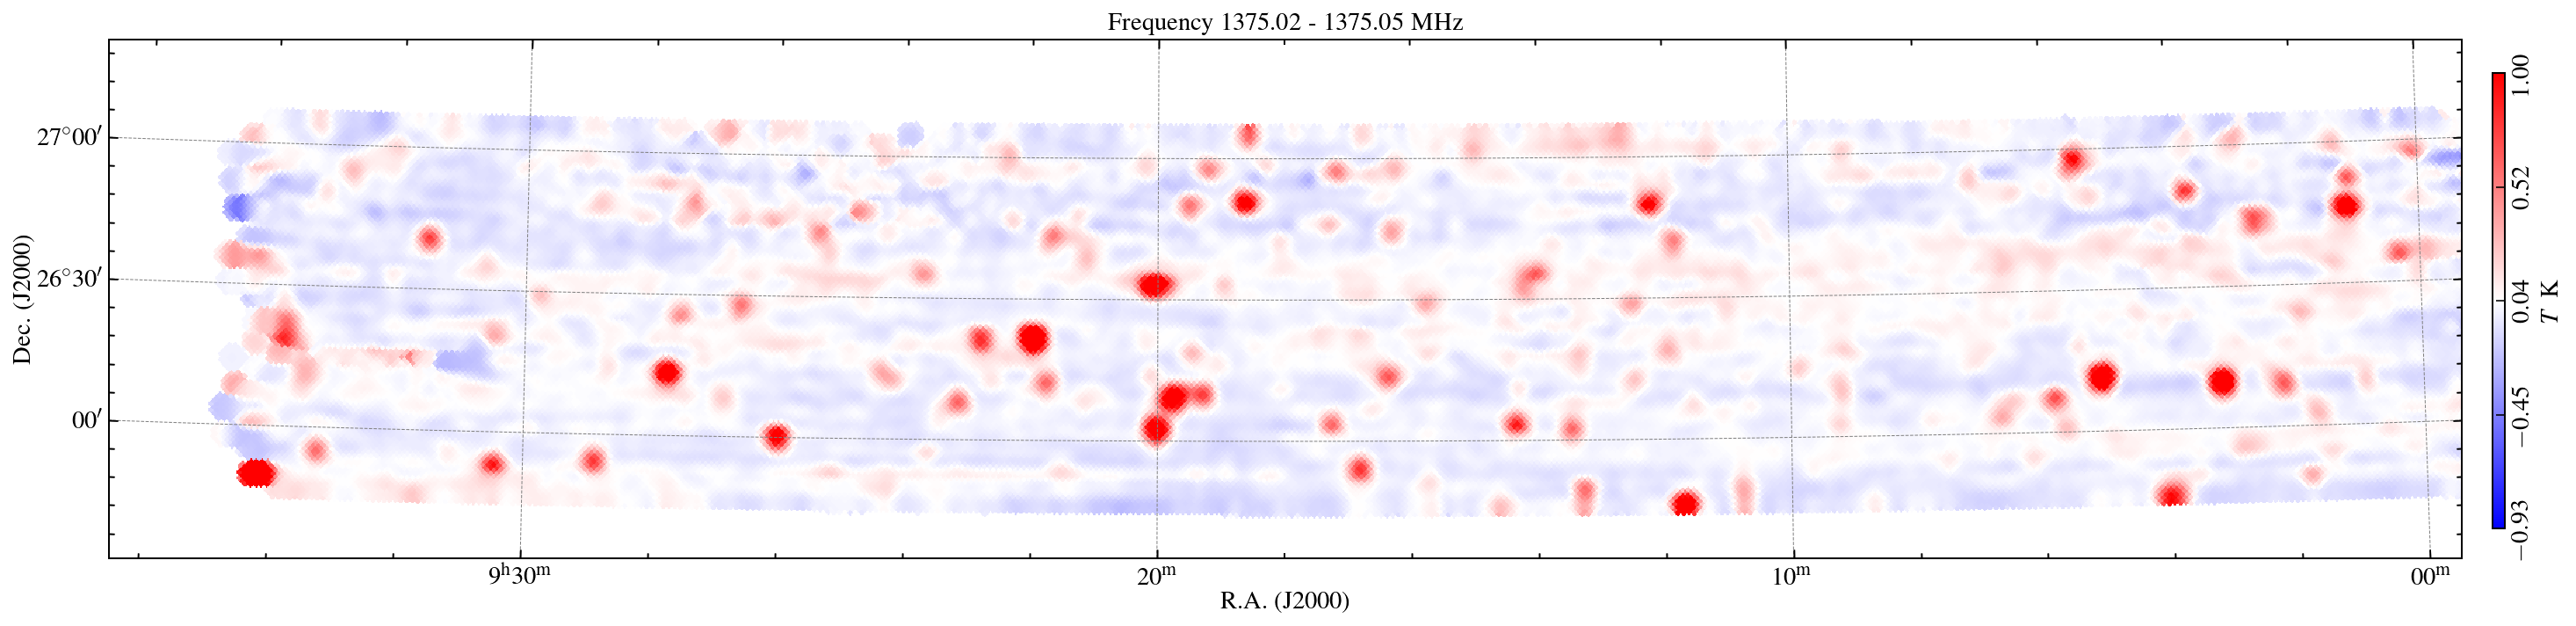

In [10]:
map_name = '/home/ycli/data/fanalysis/map_df28k_2021_test_noNW/cm_00_Combined_1250-1450MHz_vis.h5'
axes = None
nvss_path = None
indx = (slice(0, None), )
axes = plot_map.plot_map_hp(map_name, map_key='clean_map',
                         pix=0.25/60., indx=indx,
                         imap_shp = (2000, 440), axes=axes,
                         field_center=[(9.3*15, 26.5),  ],
                         figsize=(24, 6), sigma = 6,
                         title='', proj='ZEA', cmap='bwr', 
                         nvss_path=nvss_path)


## **Check flux from map using TOD sources**

In [4]:
map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_df50M_2021_grid_4096_noweight/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_info = [imap, pixs, nside]

map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod_df50M/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
sim_info = [imap, pixs, nside]

iso_threshold = 9.
flux_lim = 14
max_dist = 0.5
output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M/'%(iso_threshold, flux_lim)
#output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M_md%2.1f/'%(iso_threshold, 
#                                                                                      flux_lim,
#                                                                                      max_dist)

source_path_list = [
    output_path + '20210314_HIMGS_1100+2610.h5',
    output_path + '20210302_HIMGS_1100+2600.h5',
    #output_path + '20220210_HIMGS_1100+2600.h5',
    output_path + '20210305_HIMGS_1100+2632.h5',
    #output_path + '20210306_HIMGS_1100+2643.h5',
    output_path + '20210307_HIMGS_1100+2654.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',
    output_path + '20210313_HIMGS_1100+2621.h5',
]

results_todsource_ap0 = cfm.read_flux_tod_sources(map_info, sim_info, source_path_list, flag_iteration=0, 
                                              freq_min = 1400 - 25, freq_max = 1400 + 25,
                                              aperture_radius=0)

results_todsource_ap0p5 = cfm.read_flux_tod_sources(map_info, sim_info, source_path_list, flag_iteration=0, 
                                              freq_min = 1400 - 25, freq_max = 1400 + 25,
                                              aperture_radius=0.5)

results_todsource_ap1p0 = cfm.read_flux_tod_sources(map_info, sim_info, source_path_list, flag_iteration=0, 
                                              freq_min = 1400 - 25, freq_max = 1400 + 25,
                                              aperture_radius=1.0)

results_todsource_ap1p5 = cfm.read_flux_tod_sources(map_info, sim_info, source_path_list, flag_iteration=0, 
                                              freq_min = 1400 - 25, freq_max = 1400 + 25,
                                              aperture_radius=1.5)

/home/ycli/code/fpipe/fpipe/map/algebra.py:1054: UserWarning: Initialization argument ignored. Requisite metadata for vector already exists. Clear info dictionary if you want opposite behaviour.
  warnings.warn("Initialization argument ignored. Requisite "


81 sources used
------------------------------


/home/opt/python/anaconda3.8_parallelhdf5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


81 sources used
------------------------------
81 sources used
------------------------------
81 sources used
------------------------------


(81, 6)
0.17095618535361598
0.06345105937604643


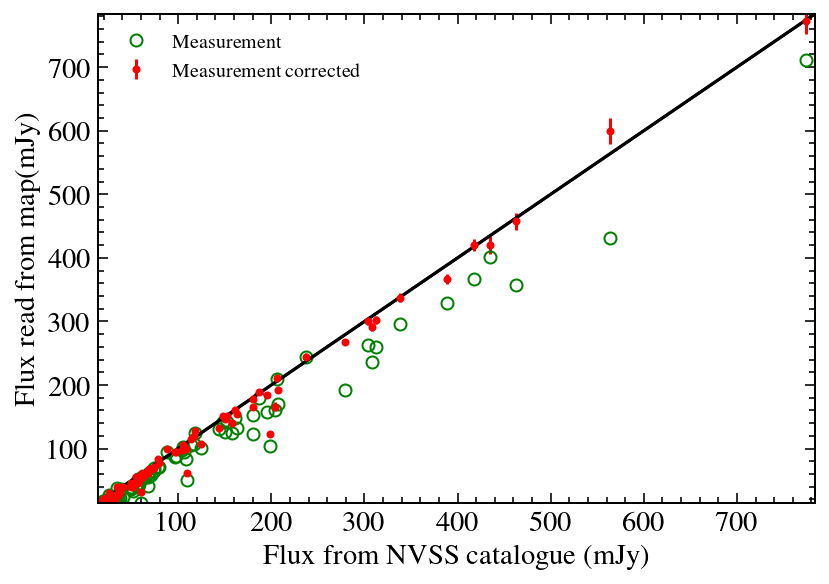

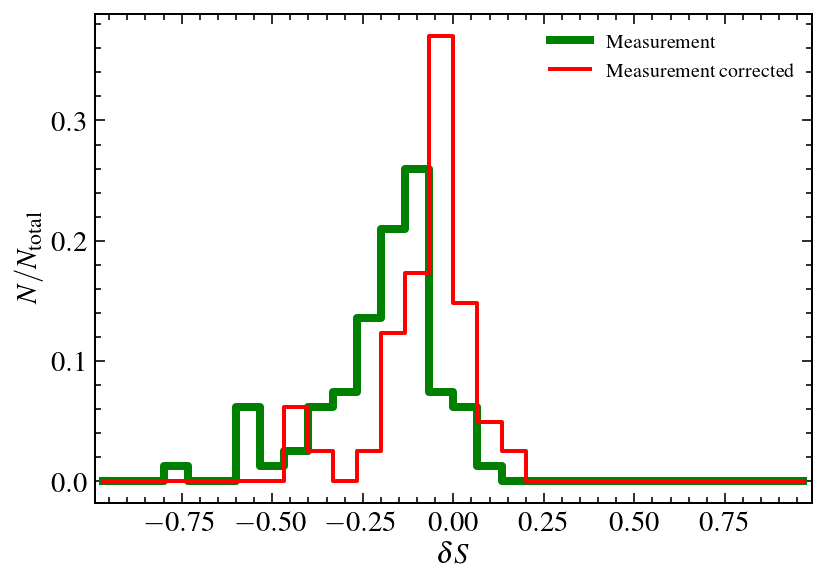

In [23]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

label = 'Measurement'
cfm.plot_fluxflux(results_todsource_ap1p5, label, axes, 'go', mfc='none', do_corr=False)

label = 'Measurement corrected'
cfm.plot_fluxflux(results_todsource_ap1p5, label, axes, 'r.', mfc='r', with_err=True)


ax.legend()
ax.set_ylabel('Flux read from map(mJy)')
ax.set_xlabel('Flux from NVSS catalogue (mJy)')
fig.savefig('./plot/fluxflux_map_tod_cat.png', format='png', dpi=200)

fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

label = 'Measurement'
cfm.plot_fluxdiffhist(results_todsource_ap1p5, label, axes, 'g-', lw=4, do_corr=False)

label = 'Measurement corrected'
cfm.plot_fluxdiffhist(results_todsource_ap1p5, label, axes, 'r-', lw=2)

ax.set_xlim(-0.99, 0.99)
ax.legend()
ax.set_ylabel(r'$N/N_{\rm total}$')
ax.set_xlabel(r'$\delta S$')
fig.savefig('./plot/fluxhist_map_tod_cat.png', format='png', dpi=200)

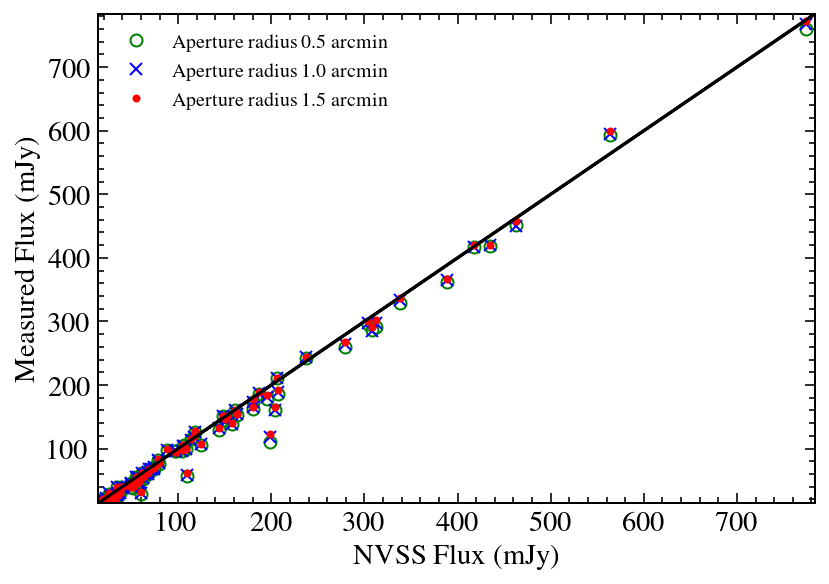

In [39]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

label = 'Aperture radius 0.5 arcmin'
cfm.plot_fluxflux(results_todsource_ap0p5, label, axes, 'go', mfc='none')

label = 'Aperture radius 1.0 arcmin'

cfm.plot_fluxflux(results_todsource_ap1p0, label, axes, 'bx', mfc='b')

label = 'Aperture radius 1.5 arcmin'
cfm.plot_fluxflux(results_todsource_ap1p5, label, axes, 'r.', mfc='r')

ax.legend()
ax.set_ylabel('Measured Flux (mJy)')
ax.set_xlabel('NVSS Flux (mJy)')
fig.savefig('./plot/fluxflux_map_tods_ap.png', format='png', dpi=200)

(81, 6)


Text(0.5, 0, 'Flux from NVSS catalogue (mJy)')

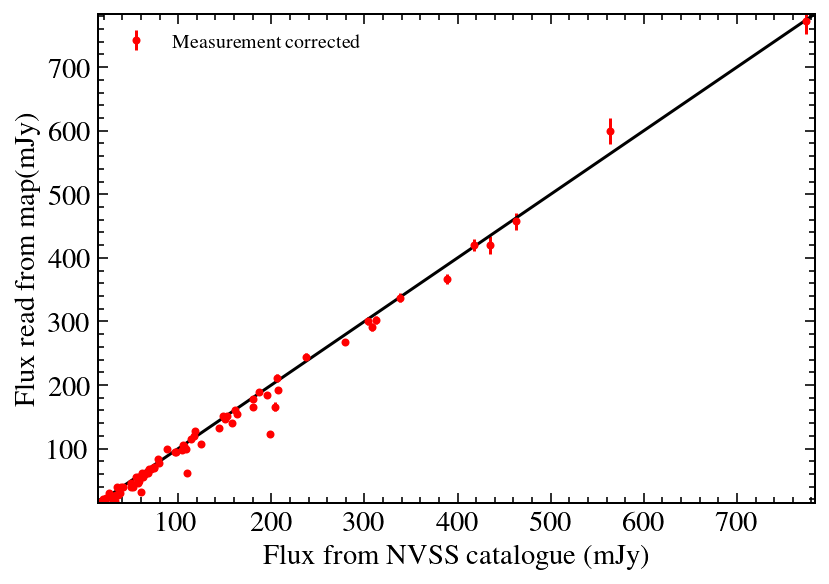

In [25]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

label = 'Measurement corrected'
cfm.plot_fluxflux(results_todsource_ap1p5, label, axes, 'r.', mfc='r', with_err=True)


ax.legend()
ax.set_ylabel('Flux read from map(mJy)')
ax.set_xlabel('Flux from NVSS catalogue (mJy)')
#fig.savefig('./plot/fluxflux_map_tod_cat.png', format='png', dpi=200)

0.07059834789204401
0.07429504409041275
0.06345105937604643


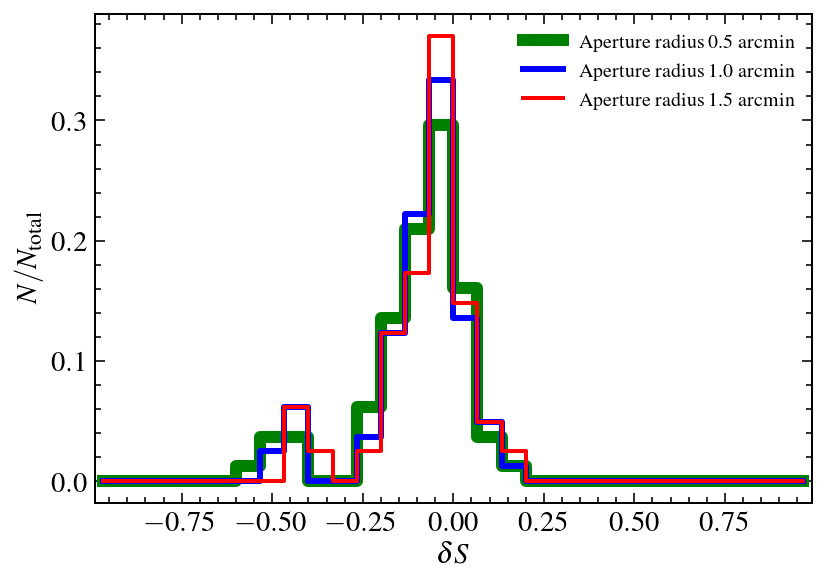

In [40]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)


label = 'Aperture radius 0.5 arcmin'
cfm.plot_fluxdiffhist(results_todsource_ap0p5, label, axes, 'g-', lw=6)

label = 'Aperture radius 1.0 arcmin'
cfm.plot_fluxdiffhist(results_todsource_ap1p0, label, axes, 'b-', lw=3)

label = 'Aperture radius 1.5 arcmin'
cfm.plot_fluxdiffhist(results_todsource_ap1p5, label, axes, 'r-', lw=2)

ax.set_xlim(-0.99, 0.99)
ax.legend()
ax.set_ylabel(r'$N/N_{\rm total}$')
ax.set_xlabel(r'$\delta S$')
fig.savefig('./plot/fluxhist_map_tod_ap.png', format='png', dpi=200)

### output catalogue

In [6]:
cfm.output_catalogue(results_todsource_ap1p5)

(81, 6)
$09\overset{\rm h}{} 03\overset{\rm m}{} 11\overset{{\rm s}}{.}67$ & $26\overset{\circ}{} 09\overset{\prime}{} 40\overset{{\prime\prime}}{.}28$ & $ 195.87$ & $ 184.04 \pm  3.88$ &$  13.35$ &$09\overset{\rm h}{} 42\overset{\rm m}{} 36\overset{{\rm s}}{.}39$ & $26\overset{\circ}{} 10\overset{\prime}{} 15\overset{{\prime\prime}}{.}27$ & $  35.09$ & $  27.41 \pm  0.90$ &$  13.08$ \\
$10\overset{\rm h}{} 18\overset{\rm m}{} 07\overset{{\rm s}}{.}13$ & $26\overset{\circ}{} 09\overset{\prime}{} 42\overset{{\prime\prime}}{.}51$ & $ 180.38$ & $ 177.66 \pm  3.80$ &$  13.99$ &$09\overset{\rm h}{} 26\overset{\rm m}{} 00\overset{{\rm s}}{.}53$ & $25\overset{\circ}{} 59\overset{\prime}{} 53\overset{{\prime\prime}}{.}30$ & $ 113.56$ & $ 115.60 \pm  2.97$ &$   9.24$ \\
$10\overset{\rm h}{} 57\overset{\rm m}{} 23\overset{{\rm s}}{.}15$ & $26\overset{\circ}{} 01\overset{\prime}{} 30\overset{{\prime\prime}}{.}18$ & $ 186.74$ & $ 188.67 \pm  4.89$ &$   4.92$ &$11\overset{\rm h}{} 34\overset{\rm m}

## **Chack NVSS cat**

In [84]:
nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]
nvss_range = [[9*15+0.5, 13*15-0.5, 25.9-0.2, 26.9+0.2],]

In [54]:
map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_df50M_2021_grid_4096_noweight/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap)
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_info = [imap, pixs, nside]

map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod_df50M/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap)
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
sim_info = [imap, pixs, nside]

### load sources from the map

In [35]:
# load full nvss sources from map
results_iso0_ap1p5 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 0, 
                    iso_threshold = 0, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=1.5, nvss_range = nvss_range)

3161 of 7823 sources left with redundancy removing
3161 of 3161 sources left with flux lim cut 0.000000 mJy


  0%|          | 0/2968 [00:00<?, ?it/s]

/home/opt/python/anaconda3.8_parallelhdf5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


2911 sources used
------------------------------


In [36]:
# load nvss sources from map with iso=10

results_iso10_ap1p5 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 0, 
                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=1.5, nvss_range = nvss_range)

3161 of 7823 sources left with redundancy removing
122 of 3161 sources left with threshold cut 10.000000 arcmin
122 of 122 sources left with flux lim cut 0.000000 mJy


  0%|          | 0/115 [00:00<?, ?it/s]

107 sources used
------------------------------


In [41]:
# load nvss sources from map with iso=10, flux limit of 20 mJy

results_iso10_ap1p5_flx20 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 20, 
                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=1.5, nvss_range = nvss_range)

3161 of 7823 sources left with redundancy removing
122 of 3161 sources left with threshold cut 10.000000 arcmin
69 of 122 sources left with flux lim cut 20.000000 mJy


  0%|          | 0/64 [00:00<?, ?it/s]

/home/opt/python/anaconda3.8_parallelhdf5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


61 sources used
------------------------------


In [50]:
# load nvss sources from map with iso=10, flux limit of 7 mJy

results_iso10_ap1p5_flx7 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 7, 
                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=1.5, nvss_range = nvss_range)

3161 of 7823 sources left with redundancy removing
122 of 3161 sources left with threshold cut 10.000000 arcmin
92 of 122 sources left with flux lim cut 7.000000 mJy


  0%|          | 0/86 [00:00<?, ?it/s]

82 sources used
------------------------------


In [37]:
# load nvss sources from map with iso=0, flux limit of 10 mJy

results_iso0_ap1p5_flx10 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 10, 
                    iso_threshold = 0, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=1.5, nvss_range = nvss_range)

3161 of 7823 sources left with redundancy removing
1176 of 3161 sources left with flux lim cut 10.000000 mJy


  0%|          | 0/1058 [00:00<?, ?it/s]

1047 sources used
------------------------------


In [38]:
# load nvss sources from map with iso=0, flux limit of 20 mJy

results_iso0_ap1p5_flx20 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 20, 
                    iso_threshold = 0, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=1.5, nvss_range = nvss_range)

3161 of 7823 sources left with redundancy removing
643 of 3161 sources left with flux lim cut 20.000000 mJy


  0%|          | 0/570 [00:00<?, ?it/s]

564 sources used
------------------------------


### load TOD selected sources from the map

In [22]:
# load full nvss sources using TOD selected sources           
iso_threshold = 0.
flux_lim = 0.
output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M/'%(iso_threshold, flux_lim)
source_path_list = [
    output_path + '20210314_HIMGS_1100+2610.h5',
    output_path + '20210302_HIMGS_1100+2600.h5',
    #output_path + '20220210_HIMGS_1100+2600.h5',
    output_path + '20210305_HIMGS_1100+2632.h5',
    #output_path + '20210306_HIMGS_1100+2643.h5',
    output_path + '20210307_HIMGS_1100+2654.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',
    output_path + '20210313_HIMGS_1100+2621.h5',
]

results_todsource_ap1p5_iso0_flx0 = cfm.read_flux_tod_sources(map_info, sim_info, source_path_list, 
                                                              flag_iteration=0,
                                                              freq_min = 1400 - 25, 
                                                              freq_max = 1400 + 25,
                                                              aperture_radius=1.5)

2760 sources used
------------------------------


In [24]:
# load nvss sources using TOD selected sources, iso 9, flux limit 7 mJy (same as TOD selection)
iso_threshold = 9
flux_lim = 7
output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M/'%(iso_threshold, flux_lim)
source_path_list = [
    output_path + '20210314_HIMGS_1100+2610.h5',
    output_path + '20210302_HIMGS_1100+2600.h5',
    #output_path + '20220210_HIMGS_1100+2600.h5',
    output_path + '20210305_HIMGS_1100+2632.h5',
    #output_path + '20210306_HIMGS_1100+2643.h5',
    output_path + '20210307_HIMGS_1100+2654.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',
    output_path + '20210313_HIMGS_1100+2621.h5',
]

results_todsource_ap1p5_iso9_flx7 = cfm.read_flux_tod_sources(map_info, sim_info, source_path_list, 
                                                              flag_iteration=0,
                                                              freq_min = 1400 - 25, 
                                                              freq_max = 1400 + 25,
                                                              aperture_radius=1.5)

/home/opt/python/anaconda3.8_parallelhdf5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


105 sources used
------------------------------


In [25]:
# load nvss sources using TOD selected sources, iso 9, flux limit 14 mJy (same as TOD selection)
iso_threshold = 9
flux_lim = 14
output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M/'%(iso_threshold, flux_lim)
source_path_list = [
    output_path + '20210314_HIMGS_1100+2610.h5',
    output_path + '20210302_HIMGS_1100+2600.h5',
    #output_path + '20220210_HIMGS_1100+2600.h5',
    output_path + '20210305_HIMGS_1100+2632.h5',
    #output_path + '20210306_HIMGS_1100+2643.h5',
    output_path + '20210307_HIMGS_1100+2654.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',
    output_path + '20210313_HIMGS_1100+2621.h5',
]

results_todsource_ap1p5_iso9_flx14 = cfm.read_flux_tod_sources(map_info, sim_info, source_path_list, 
                                                              flag_iteration=0,
                                                              freq_min = 1400 - 25, 
                                                              freq_max = 1400 + 25,
                                                              aperture_radius=1.5)

84 sources used
------------------------------


### differencial number count

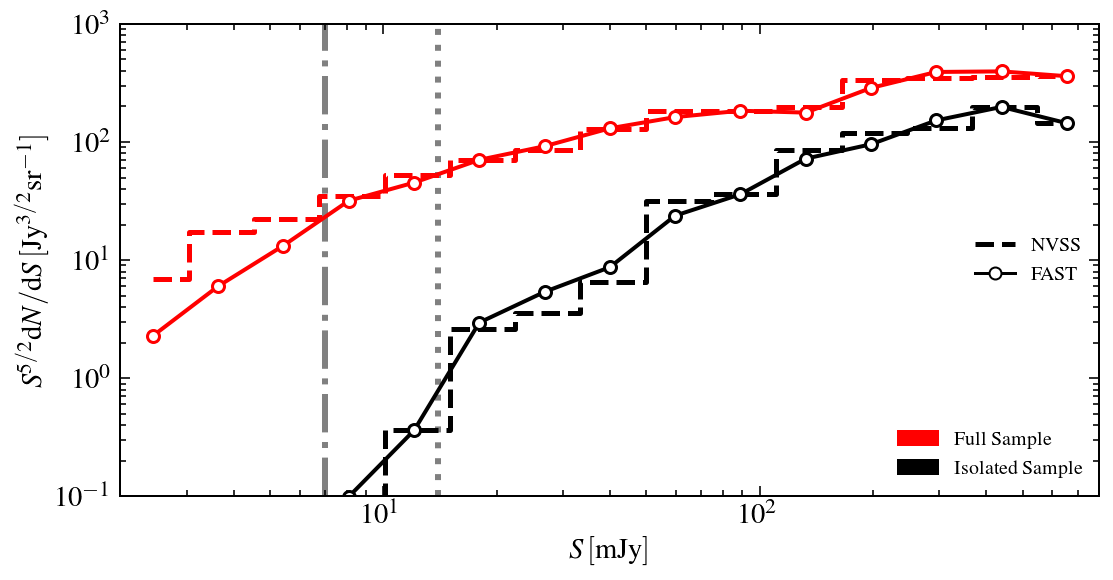

In [90]:
results_list = [results_todsource_ap1p5_iso0_flx0, results_todsource_ap1p5_iso9_flx14]
label_list = ['Full Sample', 'Isolated Sample']
cfm.plot_dNdS_multi(results_list, label_list, './plot/dNdS.png')

### relative rms

0.07048015991467284
0.05695591451175273


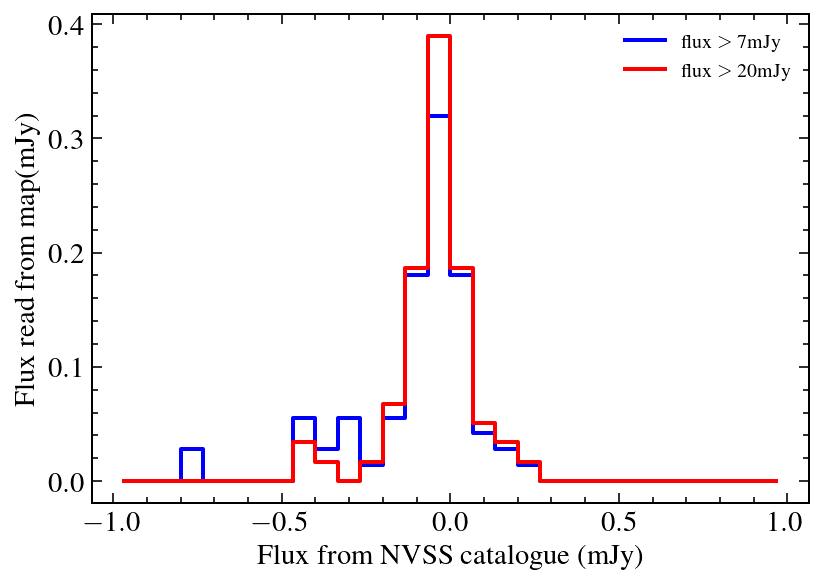

In [61]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)


label = r'flux $>$ 7mJy'
#corr = results_todsource_iso10_ap1p5_flx7[:, 2] - results_todsource_iso10_ap1p5_flx7[:, 4]
cfm.plot_fluxdiffhist(results_todsource_iso10_ap1p5_flx7, label, axes, 'b-', lw=2)

label = r'flux $>$ 20mJy'
cfm.plot_fluxdiffhist(results_todsource_iso10_ap1p5_flx20, label, axes, 'r-', lw=2)


#ax.set_xlim(0, 750)
ax.legend()
ax.set_ylabel('Flux read from map(mJy)')
ax.set_xlabel('Flux from NVSS catalogue (mJy)')
fig.savefig('./plot/fluxflux_map_cat.png', format='png', dpi=200)

## **Check source image**

In [27]:
nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]


map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_df50M_2021_grid_4096_noweight/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_weighted_info = [imap, pixs, nside]

map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod_df50M/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_simfull_info = [imap, pixs, nside]

nvss_range = [[9*15+0.5, 13*15-0.5, 25.9, 26.9],]

#results = read_flux(map_weighted_info, map_simfull_info, nvss_path, flux_lim = 20,
#                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
#                    nvss_range=nvss_range, aperture_radius=0)

iso_threshold = 9.
flux_lim = 14.
output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M/'%(iso_threshold, flux_lim)           
source_path_list = [
    output_path + '20210314_HIMGS_1100+2610.h5',
    output_path + '20210302_HIMGS_1100+2600.h5',
    #output_path + '20220210_HIMGS_1100+2600.h5',
    output_path + '20210305_HIMGS_1100+2632.h5',
    #output_path + '20210306_HIMGS_1100+2643.h5',
    output_path + '20210307_HIMGS_1100+2654.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',
    output_path + '20210313_HIMGS_1100+2621.h5',
]

results = cfm.read_flux_tod_sources(map_weighted_info, map_simfull_info, source_path_list, flag_iteration=0, 
                                    freq_min = 1400 - 25, freq_max = 1400 + 25, aperture_radius=1.5)

/home/ycli/code/fpipe/fpipe/map/algebra.py:1054: UserWarning: Initialization argument ignored. Requisite metadata for vector already exists. Clear info dictionary if you want opposite behaviour.
  warnings.warn("Initialization argument ignored. Requisite "
/home/opt/python/anaconda3.8_parallelhdf5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


81 sources used
------------------------------


In [28]:
nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]


imap, pixs, nside = map_weighted_info   
imap_full = np.zeros(hp.nside2npix(nside))
imap_full[pixs] = np.ma.median( np.ma.masked_equal(imap, 0), axis=0)
imap_full = np.ma.masked_equal(imap_full, 0)
map_info = [imap_full, pixs, nside]

isim, pixs, nside = map_simfull_info   
isim_full = np.zeros(hp.nside2npix(nside))
isim_full[pixs] = np.ma.median( np.ma.masked_equal(isim, 0), axis=0)
isim_full = np.ma.masked_equal(isim_full, 0)
sim_info = [isim_full, pixs, nside]

#plot_source_map(results, map_info, sim_info, output_prefix='cutedge_th0.5', theshold=0.2,
#                nvss_path = nvss_path, check_cat=False)

  0%|          | 0/81 [00:00<?, ?it/s]

17 of 38 sources left with redundancy removing
17 of 17 sources left with flux lim cut 2.000000 mJy


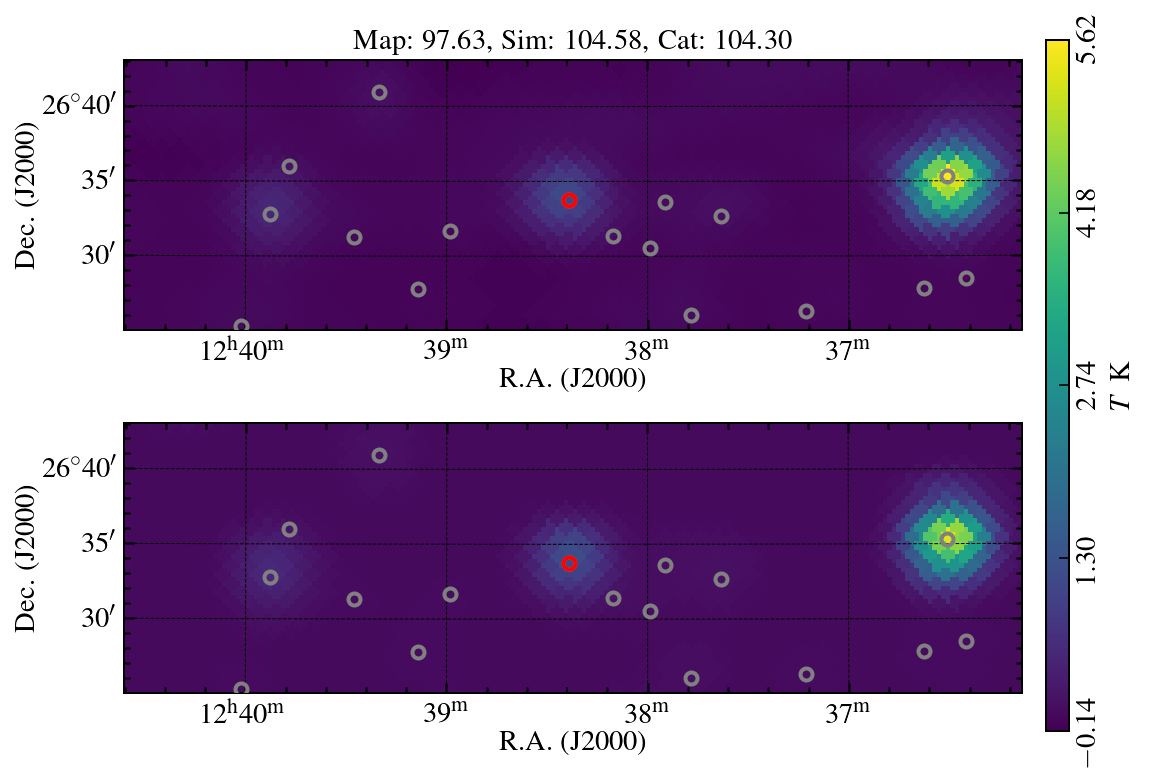

<Figure size 432x288 with 0 Axes>

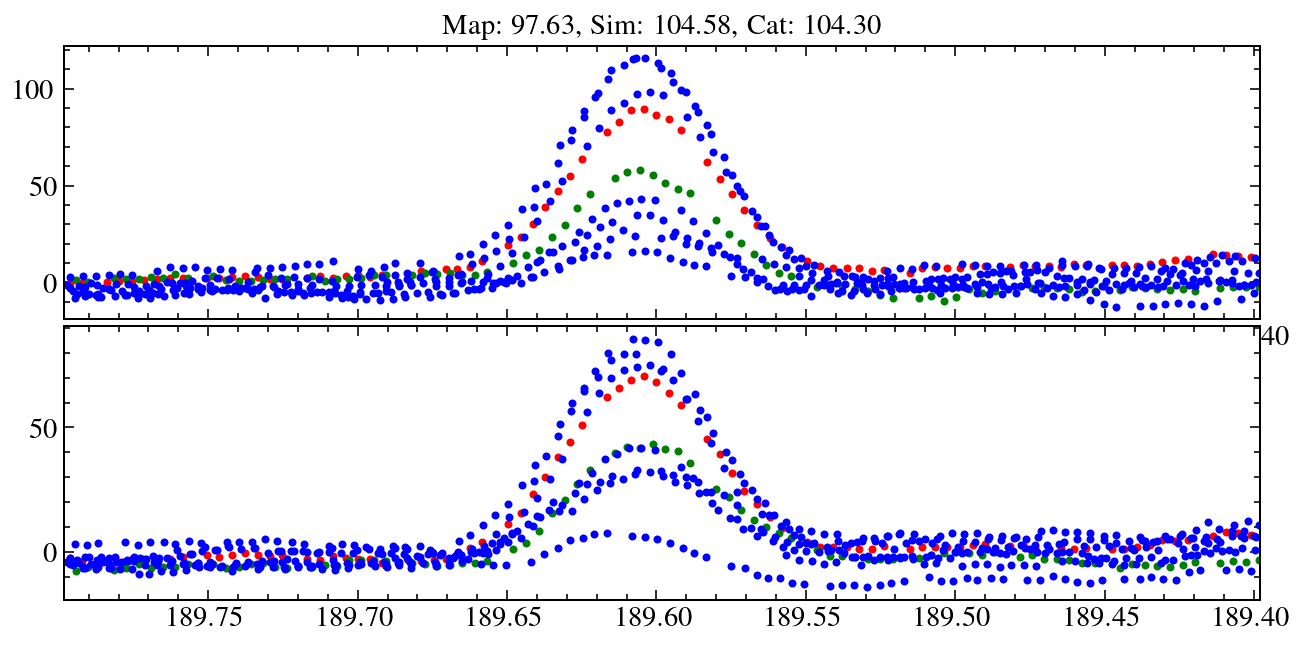

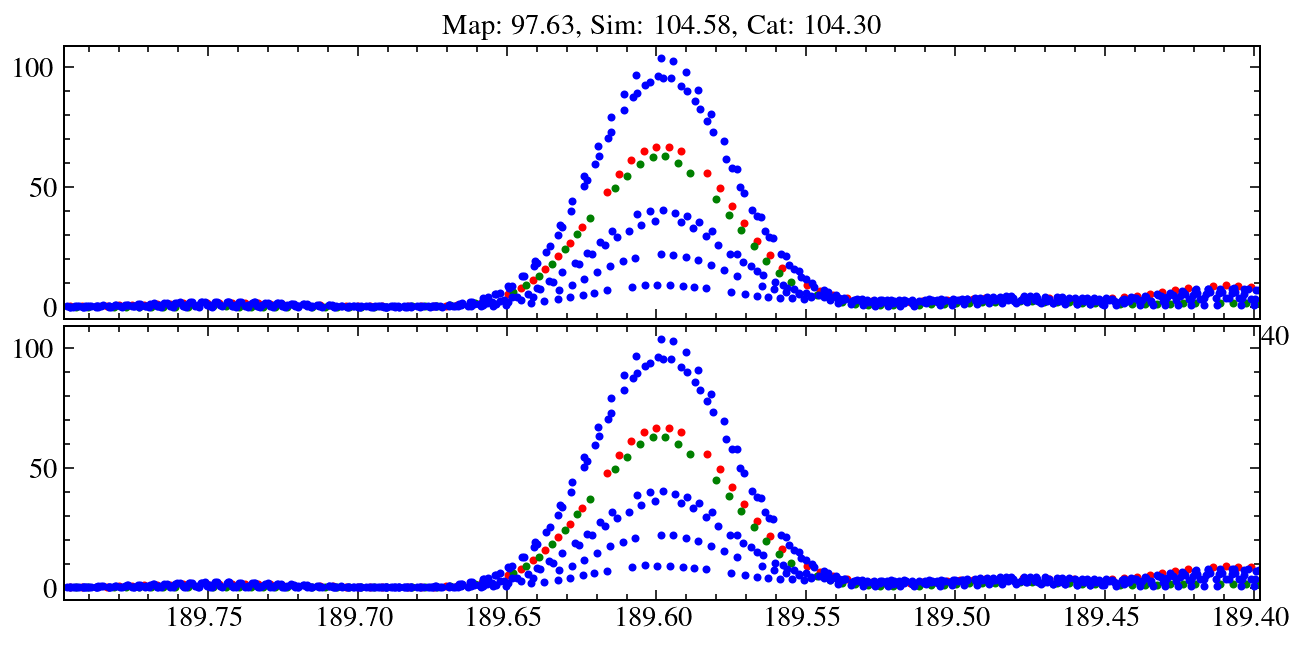

6 of 14 sources left with redundancy removing
6 of 6 sources left with flux lim cut 2.000000 mJy


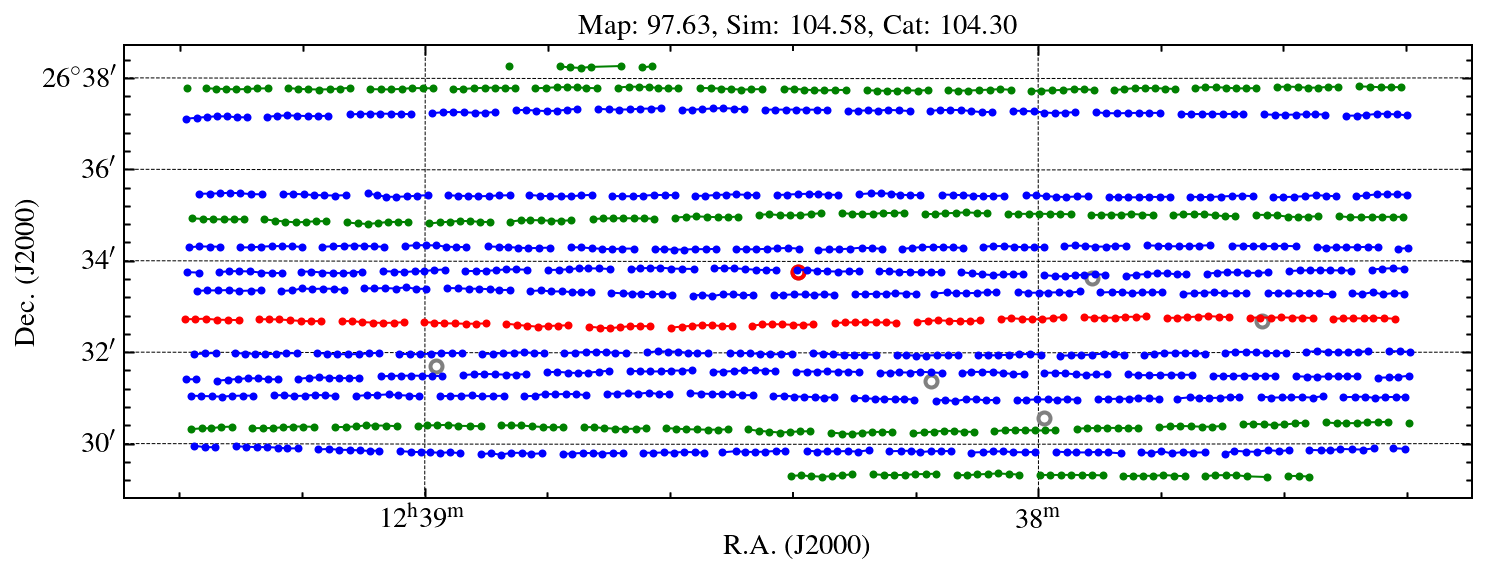

In [29]:
tod_sim = '/home/ycli/data/fanalysis/sim_nvsstod_rebin/'
tod_real = '/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC_df50M/'
cfm.plot_sim_gt_cat(results, map_info, sim_info, tod_real, tod_sim, output_prefix='df50M', 
         theshold=0.0, nvss_path=nvss_path)

In [ ]:
tod_sim = '/home/ycli/data/fanalysis/sim_nvsstod_rebin/'
tod_real = '/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC_df50M/'
cfm.plot_all(results, map_info, sim_info, tod_real, tod_sim, output_prefix='df50M', 
         theshold=0.0, nvss_path=nvss_path)

### Check source image for all isolated

In [98]:
nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]


map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_df50M_2021_grid_4096_noweight/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_weighted_info = [imap, pixs, nside]

map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod_df50M/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_simfull_info = [imap, pixs, nside]

nvss_range = [[9*15+0.5, 13*15-0.5, 25.9, 26.9],]

#results = read_flux(map_weighted_info, map_simfull_info, nvss_path, flux_lim = 20,
#                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
#                    nvss_range=nvss_range, aperture_radius=0)

iso_threshold = 9.
flux_lim = 15.

results = cfm.read_flux(map_weighted_info, map_simfull_info, nvss_path, flux_lim=flux_lim,
                        iso_threshold=iso_threshold, flag_iteration=0, 
                        freq_min = 1400 - 25, freq_max = 1400 + 25, aperture_radius=1.5,
                        nvss_range=nvss_range)

2254 of 5593 sources left with redundancy removing
170 of 2254 sources left with threshold cut 9.000000 arcmin
93 of 170 sources left with flux lim cut 15.000000 mJy


  0%|          | 0/93 [00:00<?, ?it/s]

93 sources used
------------------------------


0.0677290358838668


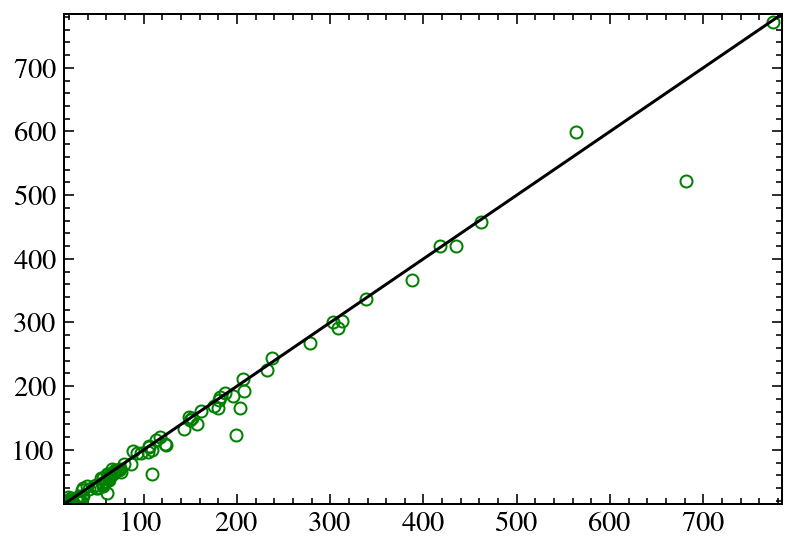

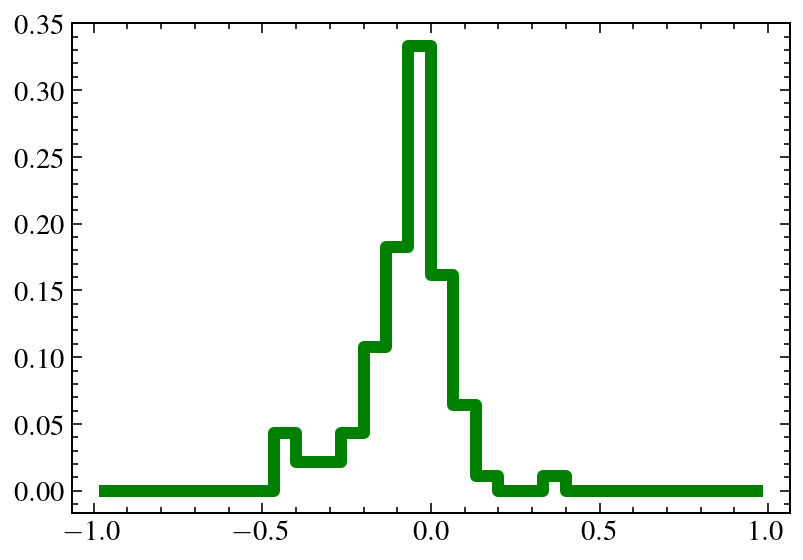

In [88]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

label = 'No flux lim'
corr = results[:, 2] - results[:, 4]
cfm.plot_fluxflux(results[:, 2],  results[:, 3] + corr, label, axes, 'go', mfc='none')

fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

label = 'No flux lim'
corr = results[:, 2] - results[:, 4]
cfm.plot_fluxdiffhist(results[:, 2],  results[:, 3] + corr, label, axes, 'g-', lw=6)


In [ ]:
tod_sim = '/home/ycli/data/fanalysis/sim_nvsstod_rebin/'
tod_real = '/home/ycli/data/fanalysis/rmbsl_sumfeeds_CC_df50M/'
cfm.plot_all(results, map_info, sim_info, tod_real, tod_sim, output_prefix='df50M', 
         theshold=0.0, nvss_path=nvss_path)

## Check Map Flux


In [68]:
23.848e-3 / cft.mJy2K(1.400) #/ (50.e6/28.e3)**0.5

1.1643481843132317

In [46]:
from astropy import units as u

In [66]:
cft.fwhm_func(None, 1.40)

array(2.90052632)

In [72]:
beam_sigma = 2.9005*u.arcmin / (2*np.sqrt(np.log(2.)))
beam_area  = np.pi*(beam_sigma)**2
equiv = u.brightness_temperature(1.40 * u.GHz)
23.848e-3 * u.K / ( (1*u.mJy/beam_area).to(u.K, equivalencies=equiv) )

<Quantity 1.15835666>

In [56]:
23.848e-3 / 63.744669

0.0003741175595405476

### check test map

In [11]:
# simulated map 
map_name = 'cm_00_Combined_1250-1450MHz_vis.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod/'

with h5py.File(map_path + map_name, 'r') as fp:
    
    isim  = al.load_h5(fp, 'clean_map')
    isim  = al.make_vect(isim, axis_names = isim.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
sim_info = [isim, pixs, nside]
# -------------------------------------------------------------------- #

# simulated map 
map_name = 'cm_00_Combined_1250-1450MHz_vis.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod_rebin/'

with h5py.File(map_path + map_name, 'r') as fp:
    
    isim  = al.load_h5(fp, 'clean_map')
    isim  = al.make_vect(isim, axis_names = isim.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
sim_rebin_info = [isim, pixs, nside]
# -------------------------------------------------------------------- #


# test map with same freq as simulation  
map_name = 'cm_00_Combined_1250-1450MHz_vis.h5'
map_path = '/home/ycli/data/fanalysis/map_df28k_2021_test_noNW/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_info = [imap, pixs, nside]
# -------------------------------------------------------------------- #


# real map with full frequency range 1420 +- 50, without noise weight
map_name = 'cm_00_Combined_1250-1450MHz_vis.h5'
map_path = '/home/ycli/data/fanalysis/map_df28k_2021_grid_4096_noNW/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_ff_info = [imap, pixs, nside]
# -------------------------------------------------------------------- #


# real map with full frequency range 1420 +- 50, with noise weight
map_name = 'cm_00_Combined_1250-1450MHz_vis.h5'
map_path = '/home/ycli/data/fanalysis/map_df28k_2021_grid_4096/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_ffw_info = [imap, pixs, nside]
# -------------------------------------------------------------------- #

/home/ycli/code/fpipe/fpipe/map/algebra.py:1045: UserWarning: Initialization argument ignored. Requisite metadata for vector already exists. Clear info dictionary if you want opposite behaviour.
  warnings.warn("Initialization argument ignored. Requisite "


In [12]:
nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]

nvss_range = [[9*15+0.5, 13*15-0.5, 25.8, 26.8],]

results_ff    = read_flux(map_ff_info,  sim_info, nvss_path, 
                          iso_threshold = 0, max_major_axis = 100, flag_iteration=5,
                          nvss_range = nvss_range)
results_ff_6  = read_flux(map_ff_info,  sim_info, nvss_path, 
                          iso_threshold = 6, max_major_axis = 100, flag_iteration=5,
                          nvss_range = nvss_range)
results_ffw_6 = read_flux(map_ffw_info, sim_info, nvss_path, 
                          iso_threshold = 6, max_major_axis = 100, flag_iteration=5,
                          nvss_range = nvss_range)

  0%|          | 0/866 [00:00<?, ?it/s]

408 of 866 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/408 [00:00<?, ?it/s]

408 of 866 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/408 [00:00<?, ?it/s]

In [13]:
results_ffw_6_ap3 = read_flux(map_ffw_info, sim_info, nvss_path, iso_threshold = 6, 
                              max_major_axis = 100, flag_iteration=5, aperture_radius=1.,
                              nvss_range = nvss_range)

results_ffw_6_ap3_rebin = read_flux(map_ffw_info, sim_rebin_info, nvss_path, iso_threshold = 6, 
                              max_major_axis = 100, flag_iteration=5, aperture_radius=1.,
                              nvss_range = nvss_range)

408 of 866 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/408 [00:00<?, ?it/s]

/home/opt/python/anaconda3.8_parallelhdf5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


408 of 866 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/408 [00:00<?, ?it/s]

In [45]:
results_sim = read_flux(sim_peak_info, sim_info, nvss_path, 
                          iso_threshold = 6, max_major_axis = 100, flag_iteration=5,
                          nvss_range = nvss_range, aperture_radius=1.,)

408 of 866 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/408 [00:00<?, ?it/s]

In [56]:
results_map_ap1 = read_flux(map_info, sim_info, nvss_path, 
                          iso_threshold = 6, max_major_axis = 100, flag_iteration=5,
                          nvss_range = nvss_range, aperture_radius=1.,)

408 of 866 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/408 [00:00<?, ?it/s]

/home/opt/python/anaconda3.8_parallelhdf5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7ff8ee43de20>)

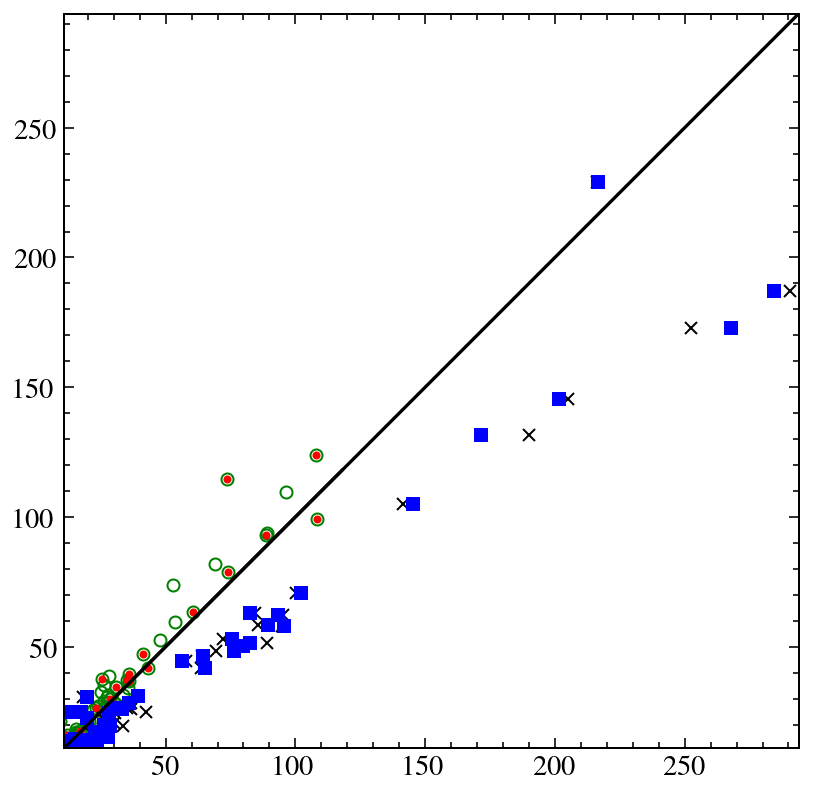

In [14]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_axes([0.1, 0.1, 0.85, 0.85])
axes = (fig, ax)

plot_fluxflux(results_ff[:, 4],    results_ff[:, 3],    axes, 'go', mfc='none')
plot_fluxflux(results_ff_6[:, 4],  results_ff_6[:, 3],  axes, 'r.')
plot_fluxflux(results_ffw_6_ap3_rebin[:, 4], results_ffw_6_ap3_rebin[:, 3], axes, 'kx')
plot_fluxflux(results_ffw_6_ap3[:, 4], results_ffw_6_ap3[:, 3], axes, 'bs')

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f09f4e65a90>)

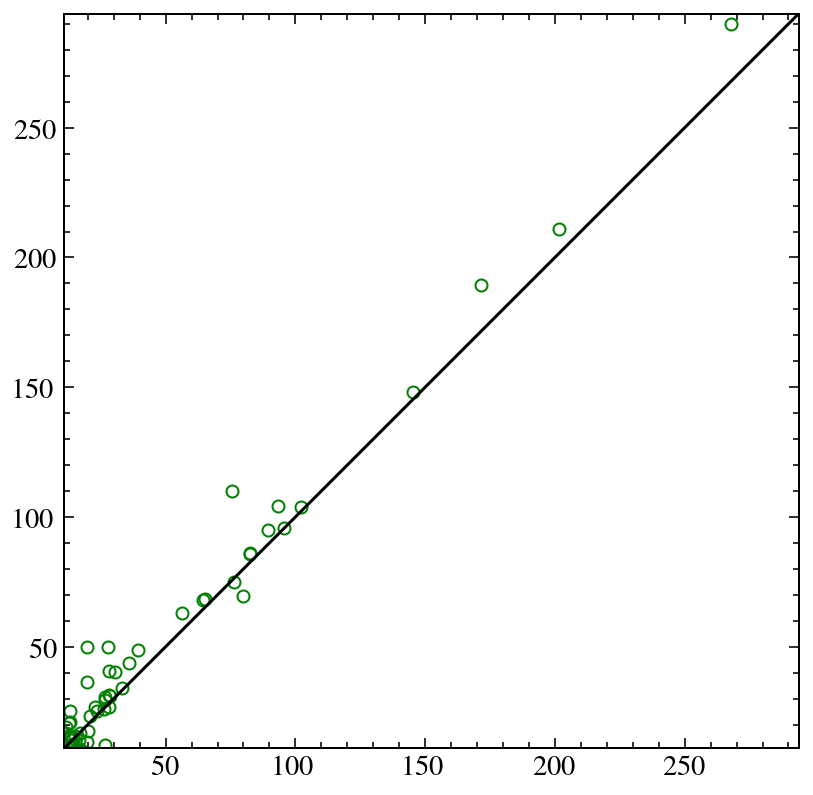

In [52]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_axes([0.1, 0.1, 0.85, 0.85])
axes = (fig, ax)

plot_fluxflux(results_map_ap1[:, 4],  results_map_ap1[:, 3], axes, 'go', mfc='none')

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f09d215ea60>)

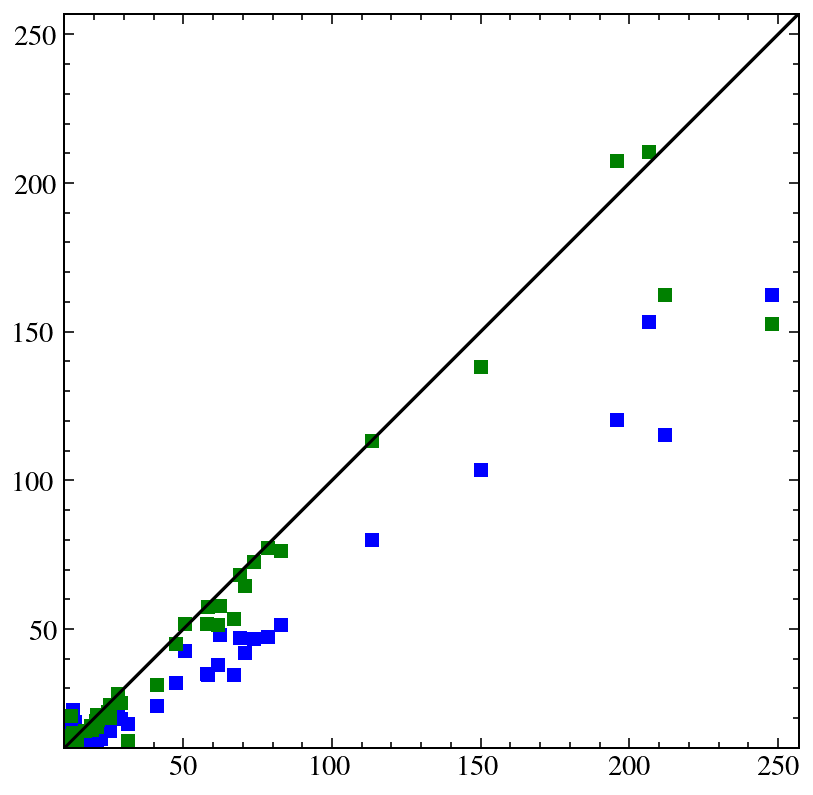

In [35]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_axes([0.1, 0.1, 0.85, 0.85])
axes = (fig, ax)

plot_fluxflux(results_ffw_6_ap3[:, 2], results_ffw_6_ap3[:, 3], axes, 'bs')
plot_fluxflux(results_ffw_6_ap3[:, 2], results_ffw_6_ap3[:, 4], axes, 'gs')

0.13483992573478276
0.11901489160579291
0.12436805026508885
0.13161777087911222


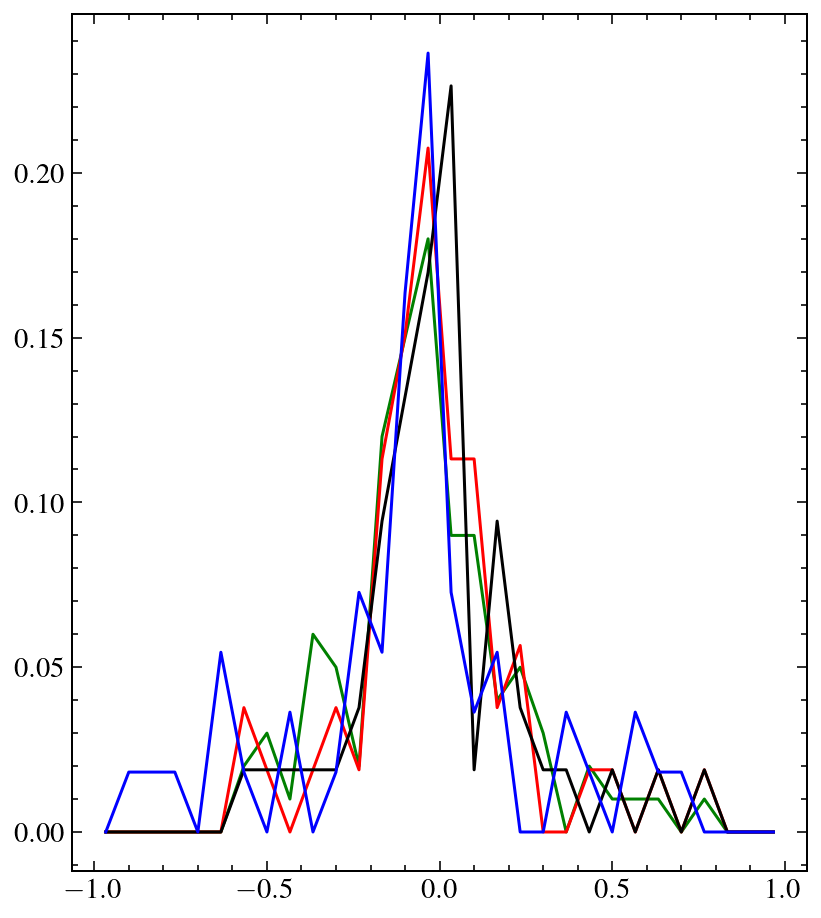

In [53]:
fig = plt.figure(figsize=(6, 7))
ax  = fig.add_axes([0.1, 0.1, 0.85, 0.85])
axes = (fig, ax)

plot_fluxdiffhist(results_ff[:, 4],    results_ff[:, 3],    axes, fmt='g-')
plot_fluxdiffhist(results_ff_6[:, 4],  results_ff_6[:, 3],  axes, fmt='r-')
plot_fluxdiffhist(results_ffw_6[:, 4], results_ffw_6[:, 3], axes, fmt='k-')
plot_fluxdiffhist(results_map_ap1[:, 4], results_map_ap1[:, 3], axes, fmt='b-')

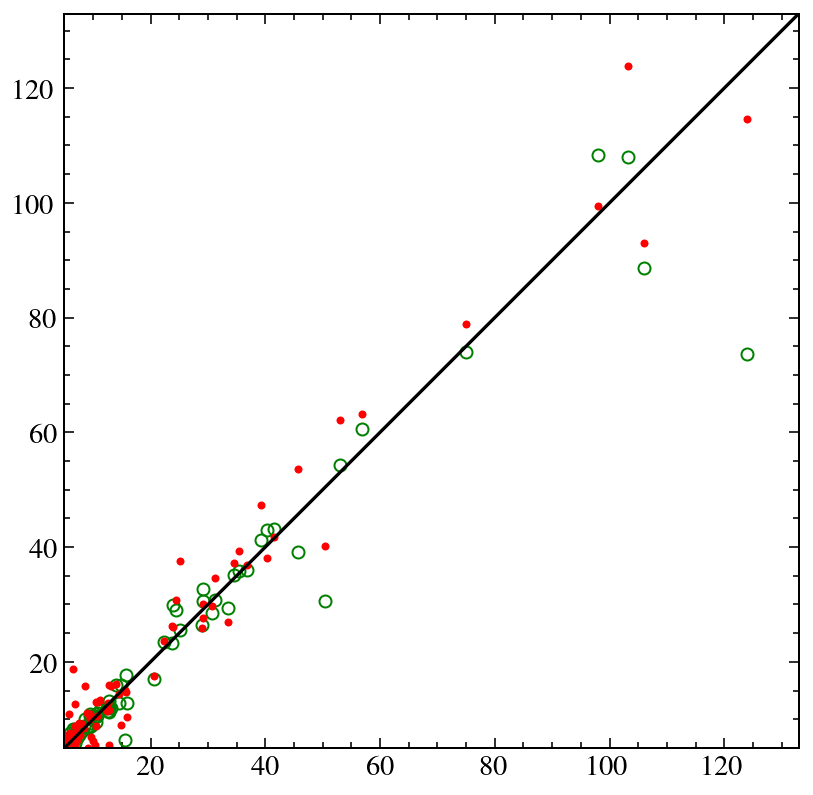

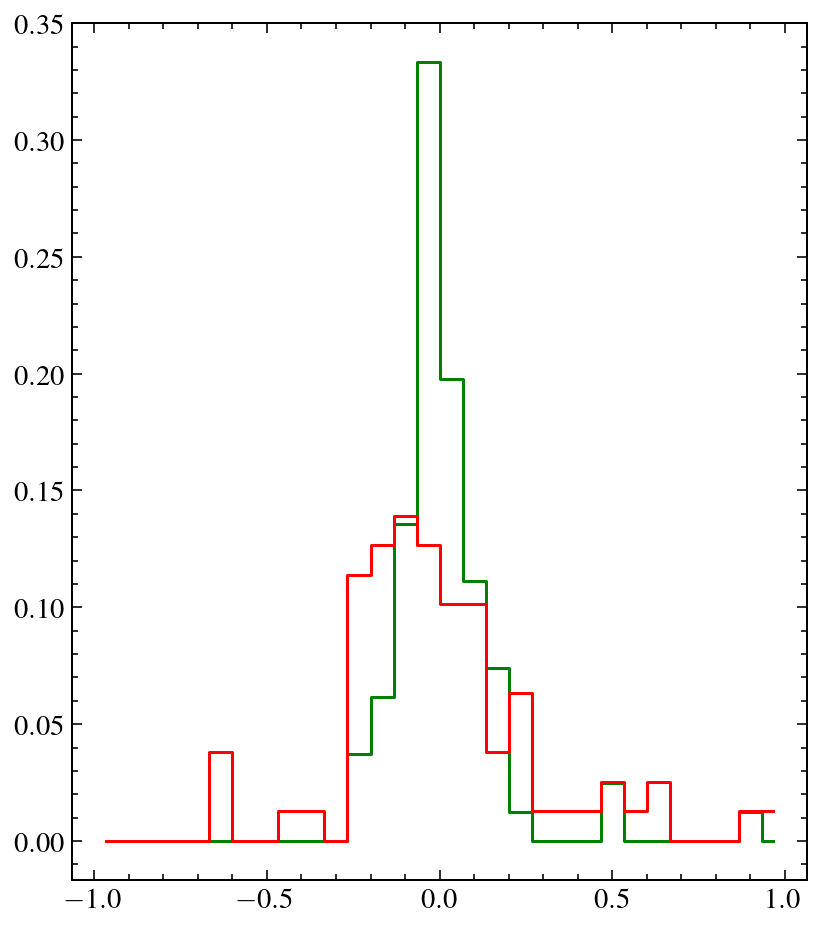

In [51]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_axes([0.1, 0.1, 0.85, 0.85])
axes = (fig, ax)

plot_fluxflux(results_ff_6[:, 2]*0.5, results_ff_6[:, 4], axes, 'go', mfc='none')
plot_fluxflux(results_ff_6[:, 2]*0.5, results_ff_6[:, 3], axes, 'r.')

fig = plt.figure(figsize=(6, 7))
ax  = fig.add_axes([0.1, 0.1, 0.85, 0.85])
axes = (fig, ax)
plot_fluxdiffhist(results_ff_6[:, 2]*0.5, results_ff_6[:, 4], axes=axes, fmt='g-')
plot_fluxdiffhist(results_ff_6[:, 2]*0.5, results_ff_6[:, 3], axes=axes, fmt='r-')

### check full frequency maps

In [17]:
map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_df28k_2021_grid_4096/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_weighted_info = [imap, pixs, nside]

map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_simfull_info = [imap, pixs, nside]

nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]


results_map_weighted_6 = read_flux(map_weighted_info, map_simfull_info, nvss_path, 
                                   iso_threshold = 6, max_major_axis = 10, flag_iteration=5,)

results_map_weighted_6_ap1 = read_flux(map_weighted_info, map_simfull_info, nvss_path, 
                                   iso_threshold = 6, max_major_axis = 10, flag_iteration=5,
                                   aperture_radius=1.)
results_map_weighted_6_ap2 = read_flux(map_weighted_info, map_simfull_info, nvss_path, 
                                   iso_threshold = 6, max_major_axis = 10, flag_iteration=5,
                                   aperture_radius=2.)

819 of 1662 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/819 [00:00<?, ?it/s]

819 of 1662 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/819 [00:00<?, ?it/s]

In [18]:
nvss_range = [[9*15+0.5, 13*15-0.5, 25.9, 26.9],]

results_map_weighted_6_ap1_cutedge = read_flux(map_weighted_info, map_simfull_info, nvss_path, 
                                   iso_threshold = 6, max_major_axis = 10, flag_iteration=5,
                                   nvss_range=nvss_range, aperture_radius=1.)
results_map_weighted_6_ap2_cutedge = read_flux(map_weighted_info, map_simfull_info, nvss_path, 
                                   iso_threshold = 6, max_major_axis = 10, flag_iteration=5,
                                   nvss_range=nvss_range, aperture_radius=2.)

405 of 831 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/405 [00:00<?, ?it/s]

405 of 831 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/405 [00:00<?, ?it/s]

518
544
386


(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fbab0eaa250>)

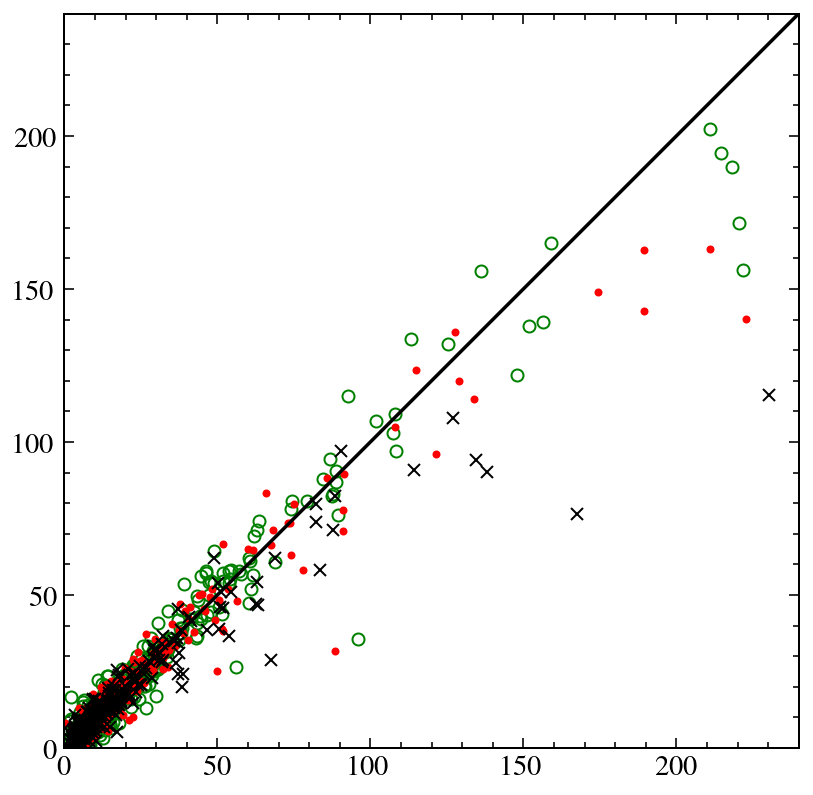

In [19]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_axes([0.1, 0.1, 0.85, 0.85])
axes = (fig, ax)

print(results_map_weighted_6.shape[0])
plot_fluxflux(results_map_weighted_6[:, 4], results_map_weighted_6[:, 3], 
              axes, 'go', mfc='none')
#plot_fluxflux(results_map_weighted_6_cutedge[:, 4], results_map_weighted_6_cutedge[:, 3],     
#              axes, 'r.', mfc='r')
print(results_map_weighted_6_ap1.shape[0])
plot_fluxflux(results_map_weighted_6_ap1_cutedge[:, 4], results_map_weighted_6_ap1_cutedge[:, 3],
              axes, 'r.')
print(results_map_weighted_6_ap1_cutedge.shape[0])
plot_fluxflux(results_map_weighted_6_ap2_cutedge[:, 4], results_map_weighted_6_ap2_cutedge[:, 3],
              axes, 'kx')

In [93]:
nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/results_map_weighted_6_ap1_cutedgeits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]

results_part_map = []

for map_id in range(7):

    map_name = 'cm_%02d_Combined_1250-1450MHz_vis.h5'%map_id
    map_path = '/home/ycli/data/fanalysis/map_df28k_2021_grid_4096/'
    with h5py.File(map_path + map_name, 'r') as fp:
        
        imap  = al.load_h5(fp, 'clean_map')
        imap  = al.make_vect(imap, axis_names = imap.info['axes'])
        pixs  = fp['map_pix'][:]
        nside = fp['nside'][()]
        
    map_weighted_info = [imap, pixs, nside]
    
    map_name = 'cm_%02d_Combined_1250-1450MHz_vis.h5'%map_id
    map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod/'
    with h5py.File(map_path + map_name, 'r') as fp:
        
        imap  = al.load_h5(fp, 'clean_map')
        imap  = al.make_vect(imap, axis_names = imap.info['axes'])
        pixs  = fp['map_pix'][:]
        nside = fp['nside'][()]
        
    map_simfull_info = [imap, pixs, nside]
    
    
    results_part_map.append( read_flux(map_weighted_info, map_simfull_info, nvss_path, 
                                       iso_threshold = 6, max_major_axis = 100, 
                                       flag_iteration=5) )
    
#results_part_map = np.concatenate(results_part_map, axis=0)
#results_part_map = np.array(results_part_map, axis=0)
#print(results_part_map.shape)

/home/ycli/code/fpipe/fpipe/map/algebra.py:1045: UserWarning: Initialization argument ignored. Requisite metadata for vector already exists. Clear info dictionary if you want opposite behaviour.
  warnings.warn("Initialization argument ignored. Requisite "


131 of 274 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/131 [00:00<?, ?it/s]

130 of 328 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/130 [00:00<?, ?it/s]

135 of 272 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/135 [00:00<?, ?it/s]

135 of 283 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/135 [00:00<?, ?it/s]

89 of 203 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/89 [00:00<?, ?it/s]

116 of 241 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/116 [00:00<?, ?it/s]

159 of 335 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/159 [00:00<?, ?it/s]

In [90]:
print(results_map_weighted_6.shape)

(517, 5)



0.16192009584607808
0.1865607193595893
0.23430345312579998


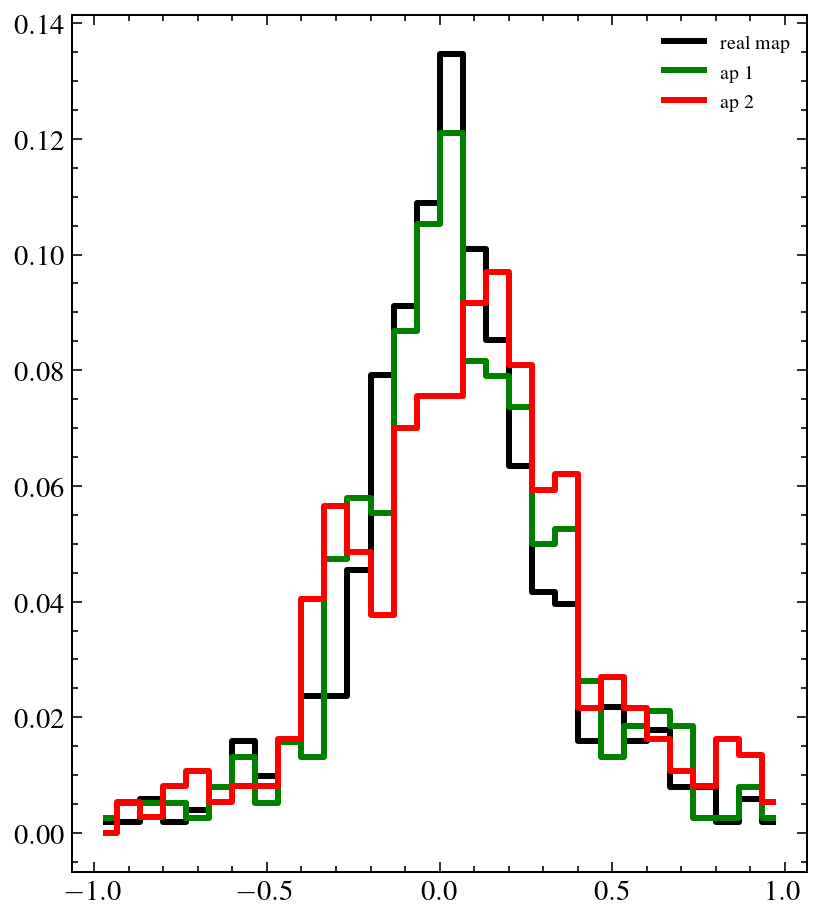

In [20]:
fig = plt.figure(figsize=(6, 7))
ax  = fig.add_axes([0.1, 0.1, 0.85, 0.85])
axes = (fig, ax)

#for i in range(7):
#    plot_fluxdiffhist(results_part_map[i][:, 4], results_part_map[i][:, 3], axes, '-', 
#                      label='%02d'%i, drawstyle='steps-mid', lw=2)
    
print()
plot_fluxdiffhist(results_map_weighted_6[:, 4], results_map_weighted_6[:, 3], axes, 'k-', 
                  label='real map', drawstyle='steps-mid', lw=3)
plot_fluxdiffhist(results_map_weighted_6_ap1_cutedge[:, 4], results_map_weighted_6_ap1_cutedge[:, 3], axes, 'g-', 
                  label='ap 1', drawstyle='steps-mid', lw=3)
plot_fluxdiffhist(results_map_weighted_6_ap2_cutedge[:, 4], results_map_weighted_6_ap2_cutedge[:, 3], axes, 'r-', 
                  label='ap 2', drawstyle='steps-mid', lw=3)
ax.legend()

### check rebin

In [5]:
map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_df50M_2021_grid_4096_noweight/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap)
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
map_info = [imap, pixs, nside]

map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod_df50M/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap)
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
sim_info = [imap, pixs, nside]

nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]

nvss_range = [[9*15+0.5, 13*15-0.5, 25.0, 27.5],]


results_iso6 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 20, 
                    iso_threshold = 6, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=0, nvss_range = nvss_range)
results_iso8 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 20, 
                    iso_threshold = 8, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=0, nvss_range = nvss_range)
results_iso10 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 20, 
                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=0, nvss_range = nvss_range)

1446 of 5633 sources left with threshold cut 6.000000 arcmin


  0%|          | 0/471 [00:00<?, ?it/s]

265 sources used
------------------------------
701 of 5633 sources left with threshold cut 8.000000 arcmin


  0%|          | 0/336 [00:00<?, ?it/s]

183 sources used
------------------------------
334 of 5633 sources left with threshold cut 10.000000 arcmin


  0%|          | 0/217 [00:00<?, ?it/s]

113 sources used
------------------------------


In [7]:
results_iso10_ap0p5 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 20, 
                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=0.5, nvss_range = nvss_range)
results_iso10_ap1p0 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 20, 
                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=1.0, nvss_range = nvss_range)
results_iso10_ap1p5 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 20, 
                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=1.5, nvss_range = nvss_range)
results_iso10_ap2p0 = cfm.read_flux(map_info, sim_info, nvss_path, flux_lim = 20, 
                    iso_threshold = 10, max_major_axis = 10, flag_iteration=0,
                    aperture_radius=2.0, nvss_range = nvss_range)

334 of 5633 sources left with threshold cut 10.000000 arcmin


  0%|          | 0/217 [00:00<?, ?it/s]

/home/opt/python/anaconda3.8_parallelhdf5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


116 sources used
------------------------------
334 of 5633 sources left with threshold cut 10.000000 arcmin


  0%|          | 0/217 [00:00<?, ?it/s]

116 sources used
------------------------------
334 of 5633 sources left with threshold cut 10.000000 arcmin


  0%|          | 0/217 [00:00<?, ?it/s]

117 sources used
------------------------------
334 of 5633 sources left with threshold cut 10.000000 arcmin


  0%|          | 0/217 [00:00<?, ?it/s]

118 sources used
------------------------------


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


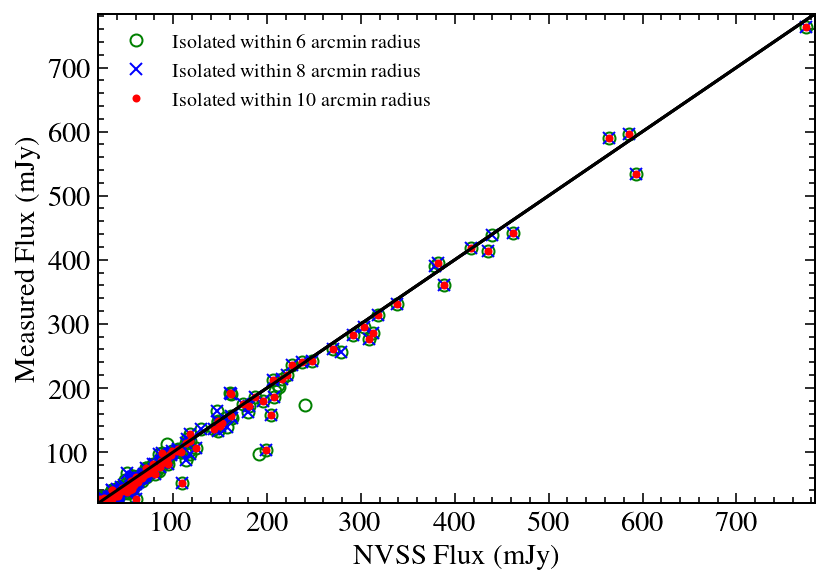

In [11]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

#print(results.shape[0])
label = 'Isolated within 6 arcmin radius'
corr = results_iso6[:, 2] - results_iso6[:, 4]
cfm.plot_fluxflux(results_iso6[:, 2],  results_iso6[:, 3] + corr,  label, axes, 'go', mfc='none')

label = 'Isolated within 8 arcmin radius'
corr = results_iso8[:, 2] - results_iso8[:, 4]
cfm.plot_fluxflux(results_iso8[:, 2],  results_iso8[:, 3] + corr,  label, axes, 'bx', mfc='b')

label = 'Isolated within 10 arcmin radius'
corr = results_iso10[:, 2] - results_iso10[:, 4]
cfm.plot_fluxflux(results_iso10[:, 2], results_iso10[:, 3] + corr, label, axes,  'r.', mfc='r')

ax.legend()
ax.set_ylabel('Measured Flux (mJy)')
ax.set_xlabel('NVSS Flux (mJy)')
fig.savefig('./plot/fluxflux_map_iso.png', format='png', dpi=200)

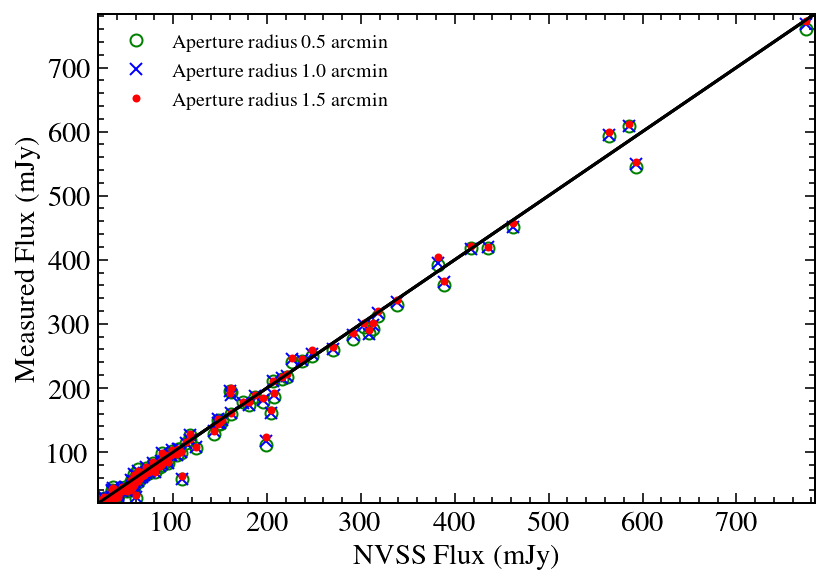

In [12]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

label = 'Aperture radius 0.5 arcmin'
corr = results_iso10_ap0p5[:, 2] - results_iso10_ap0p5[:, 4]
cfm.plot_fluxflux(results_iso10_ap0p5[:, 2], results_iso10_ap0p5[:, 3] + corr, label, axes, 'go', mfc='none')

label = 'Aperture radius 1.0 arcmin'
corr = results_iso10_ap1p0[:, 2] - results_iso10_ap1p0[:, 4]
cfm.plot_fluxflux(results_iso10_ap1p0[:, 2], results_iso10_ap1p0[:, 3] + corr, label, axes, 'bx', mfc='b')

label = 'Aperture radius 1.5 arcmin'
corr = results_iso10_ap1p5[:, 2] - results_iso10_ap1p5[:, 4]
cfm.plot_fluxflux(results_iso10_ap1p5[:, 2], results_iso10_ap1p5[:, 3] + corr, label, axes, 'r.', mfc='r')

ax.legend()
ax.set_ylabel('Measured Flux (mJy)')
ax.set_xlabel('NVSS Flux (mJy)')
fig.savefig('./plot/fluxflux_map_ap.png', format='png', dpi=200)

0.09945311215224852
0.08853325949372752
0.0751535644890548


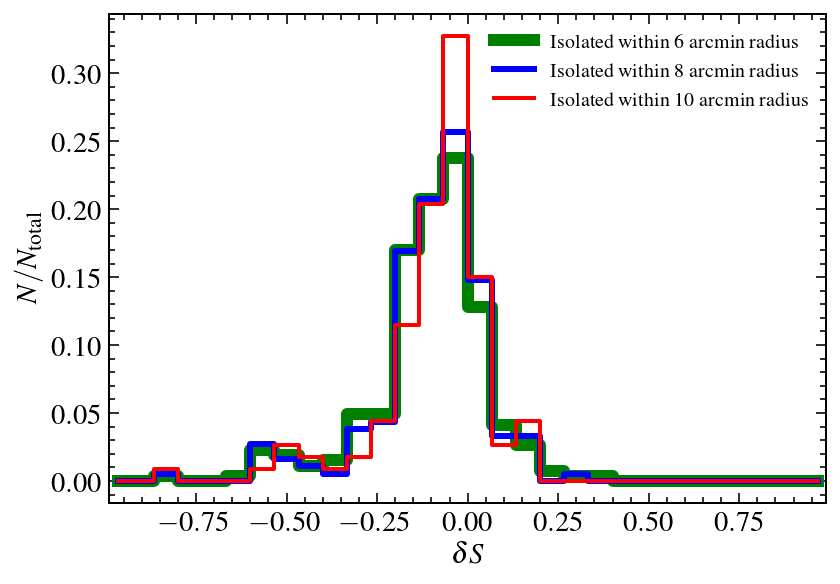

In [13]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

label = 'Isolated within 6 arcmin radius'
corr = results_iso6[:, 2] - results_iso6[:, 4]
cfm.plot_fluxdiffhist(results_iso6[:, 2],  results_iso6[:, 3] + corr,  label, axes, 'g-', lw=6)

label = 'Isolated within 8 arcmin radius'
corr = results_iso8[:, 2] - results_iso8[:, 4]
cfm.plot_fluxdiffhist(results_iso8[:, 2],  results_iso8[:, 3] + corr,  label, axes, 'b-', lw=3)

label = 'Isolated within 10 arcmin radius'
corr = results_iso10[:, 2] - results_iso10[:, 4]
cfm.plot_fluxdiffhist(results_iso10[:, 2], results_iso10[:, 3] + corr, label, axes, 'r-', lw=2)

ax.set_xlim(-0.99, 0.99)
ax.legend()
ax.set_ylabel(r'$N/N_{\rm total}$')
ax.set_xlabel(r'$\delta S$')
fig.savefig('./plot/fluxhist_map_iso.png', format='png', dpi=200)

0.07825654833113004
0.0755304766071581
0.0679779016753808


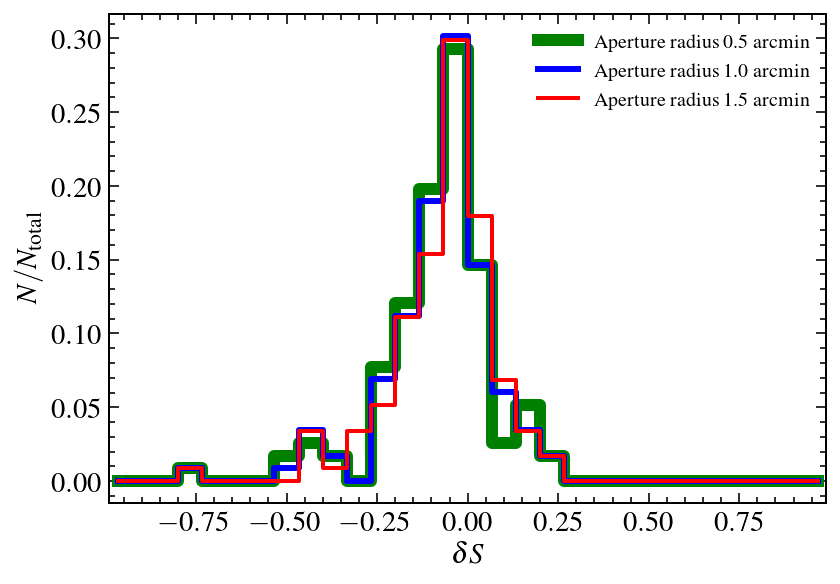

In [14]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

#label = 'Center pixel only'
#corr = results_iso10[:, 2] - results_iso10[:, 4]
#plot_fluxdiffhist(results_iso10[:, 2], results_iso10[:, 3] + corr, label, axes, 'k-', lw=6)

label = 'Aperture radius 0.5 arcmin'
corr = results_iso10_ap0p5[:, 2] - results_iso10_ap0p5[:, 4]
cfm.plot_fluxdiffhist(results_iso10_ap0p5[:, 2], results_iso10_ap0p5[:, 3] + corr, label, axes, 'g-', lw=6)

label = 'Aperture radius 1.0 arcmin'
corr = results_iso10_ap1p0[:, 2] - results_iso10_ap1p0[:, 4]
cfm.plot_fluxdiffhist(results_iso10_ap1p0[:, 2], results_iso10_ap1p0[:, 3] + corr, label, axes, 'b-', lw=3)

label = 'Aperture radius 1.5 arcmin'
corr = results_iso10_ap1p5[:, 2] - results_iso10_ap1p5[:, 4]
cfm.plot_fluxdiffhist(results_iso10_ap1p5[:, 2], results_iso10_ap1p5[:, 3] + corr, label, axes, 'r-', lw=2)

ax.set_xlim(-0.99, 0.99)
ax.legend()
ax.set_ylabel(r'$N/N_{\rm total}$')
ax.set_xlabel(r'$\delta S$')
fig.savefig('./plot/fluxhist_map_ap.png', format='png', dpi=200)

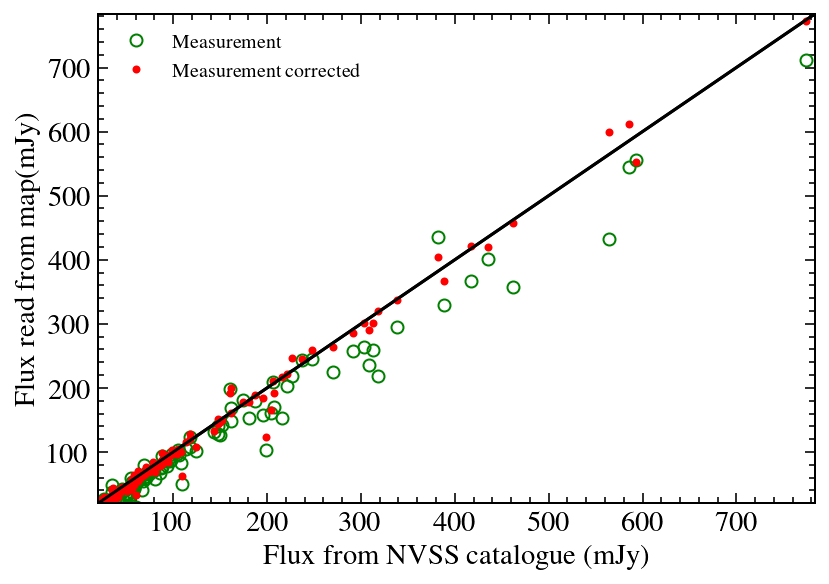

In [15]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

#label = 'Simulated'
#plot_fluxflux(results_iso10_ap1p5[:, 2], results_iso10_ap1p5[:, 4], label, axes, 'ko', mfc='none')

label = 'Measurement'
cfm.plot_fluxflux(results_iso10_ap1p5[:, 2], results_iso10_ap1p5[:, 3], label, axes, 'go', mfc='none')

label = 'Measurement corrected'
corr = results_iso10_ap1p5[:, 2] - results_iso10_ap1p5[:, 4]
cfm.plot_fluxflux(results_iso10_ap1p5[:, 2], results_iso10_ap1p5[:, 3] + corr, label, axes, 'r.', mfc='r')


ax.legend()
ax.set_ylabel('Flux read from map(mJy)')
ax.set_xlabel('Flux from NVSS catalogue (mJy)')
fig.savefig('./plot/fluxflux_map_cat.png', format='png', dpi=200)

### check simulation without mask

In [128]:
#map_name = 'cm_00_Combined_1250-1450MHz_vis.h5'
map_name = 'cm_Combined_1250-1450MHz.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod_df50M_NoMask_NoBadBeam/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
sim_info = [imap, pixs, nside]

#map_name = 'cm_00_Combined_1250-1450MHz_vis.h5'
map_path = '/home/ycli/data/fanalysis/map_sim_nvsstod_df50M/'
with h5py.File(map_path + map_name, 'r') as fp:
    
    imap  = al.load_h5(fp, 'clean_map')
    imap  = al.make_vect(imap, axis_names = imap.info['axes'])
    pixs  = fp['map_pix'][:]
    nside = fp['nside'][()]
    
sim_mask_info = [imap, pixs, nside]

iso_threshold = 10.
flux_lim = 15.
output_path = '/home/DATA/ycli/fanalysis/check/nvss_tod_iso%d_flim%d_df50M/'%(iso_threshold, flux_lim)           
source_path_list = [
    output_path + '20210314_HIMGS_1100+2610.h5',
    output_path + '20210302_HIMGS_1100+2600.h5',
    #output_path + '20220210_HIMGS_1100+2600.h5',
    output_path + '20210305_HIMGS_1100+2632.h5',
    #output_path + '20210306_HIMGS_1100+2643.h5',
    output_path + '20210307_HIMGS_1100+2654.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',
    output_path + '20210313_HIMGS_1100+2621.h5',
]

results_sim_mask = cft.read_flux_tod_sources(sim_mask_info, sim_info, source_path_list, flag_iteration=0, 
                                         freq_min = 1400 - 25, freq_max = 1400 + 25,
                                         aperture_radius=1.0)

BadBeam03
BadBeam05
BadBeam06
BadBeam06
BadBeam06
BadBeam10
BadBeam10
BadBeam10
BadBeam10
BadBeam12
BadBeam16
BadBeam16
BadBeam17
BadBeam19
BadBeam19
116 sources used
------------------------------


0.11707161040938373
0.04975505956049244


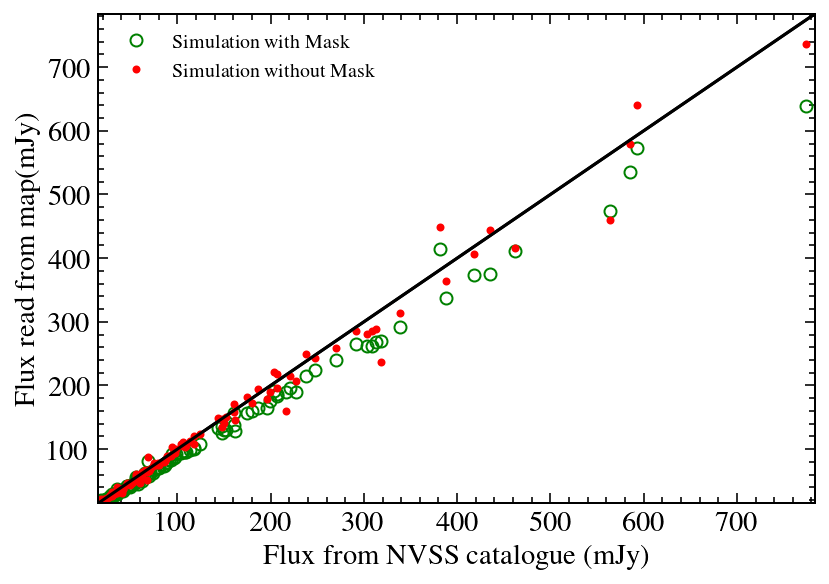

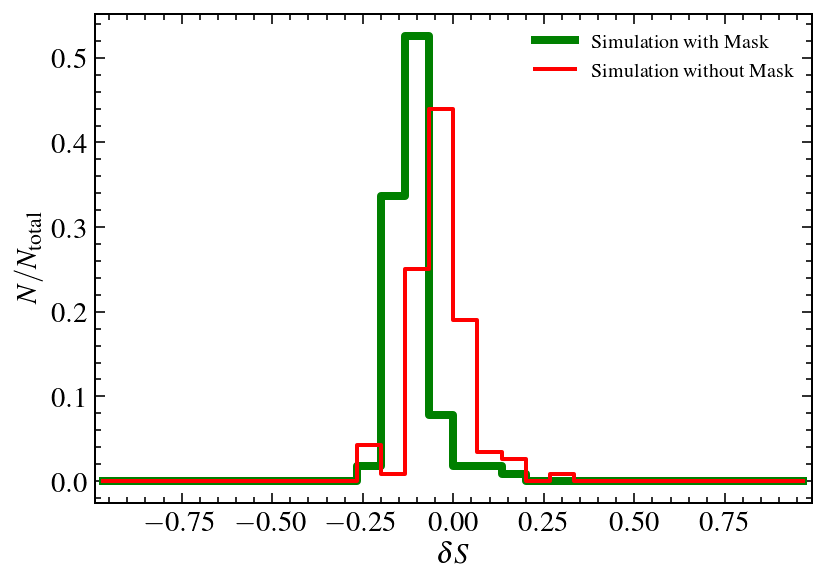

In [129]:
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

#label = 'Simulated'
#plot_fluxflux(results_iso10_ap1p5[:, 2], results_iso10_ap1p5[:, 4], label, axes, 'ko', mfc='none')

label = 'Simulation with Mask'
plot_fluxflux(results_sim_mask[:, 2], results_sim_mask[:, 4], label, axes, 'go', mfc='none')

label = 'Simulation without Mask'
#corr = results_todsource_ap1p5[:, 2] - results_todsource_ap1p5[:, 4]
plot_fluxflux(results_sim_mask[:, 2], results_sim_mask[:, 3], label, axes, 'r.', mfc='r')


ax.legend()
ax.set_ylabel('Flux read from map(mJy)')
ax.set_xlabel('Flux from NVSS catalogue (mJy)')
fig.savefig('./plot/fluxflux_sim_mask_cat.png', format='png', dpi=200)

fig = plt.figure(figsize=(6, 4))
ax  = fig.add_axes([0.12, 0.12, 0.83, 0.85])
axes = (fig, ax)

label = 'Simulation with Mask'
plot_fluxdiffhist(results_sim_mask[:, 2], results_sim_mask[:, 4], label, axes, 'g-', lw=4)

label = 'Simulation without Mask'
plot_fluxdiffhist(results_sim_mask[:, 2], results_sim_mask[:, 3], label, axes, 'r-', lw=2)

ax.set_xlim(-0.99, 0.99)
ax.legend()
ax.set_ylabel(r'$N/N_{\rm total}$')
ax.set_xlabel(r'$\delta S$')
fig.savefig('./plot/fluxhist_sim_mask_cat.png', format='png', dpi=200)

  0%|          | 0/116 [00:00<?, ?it/s]

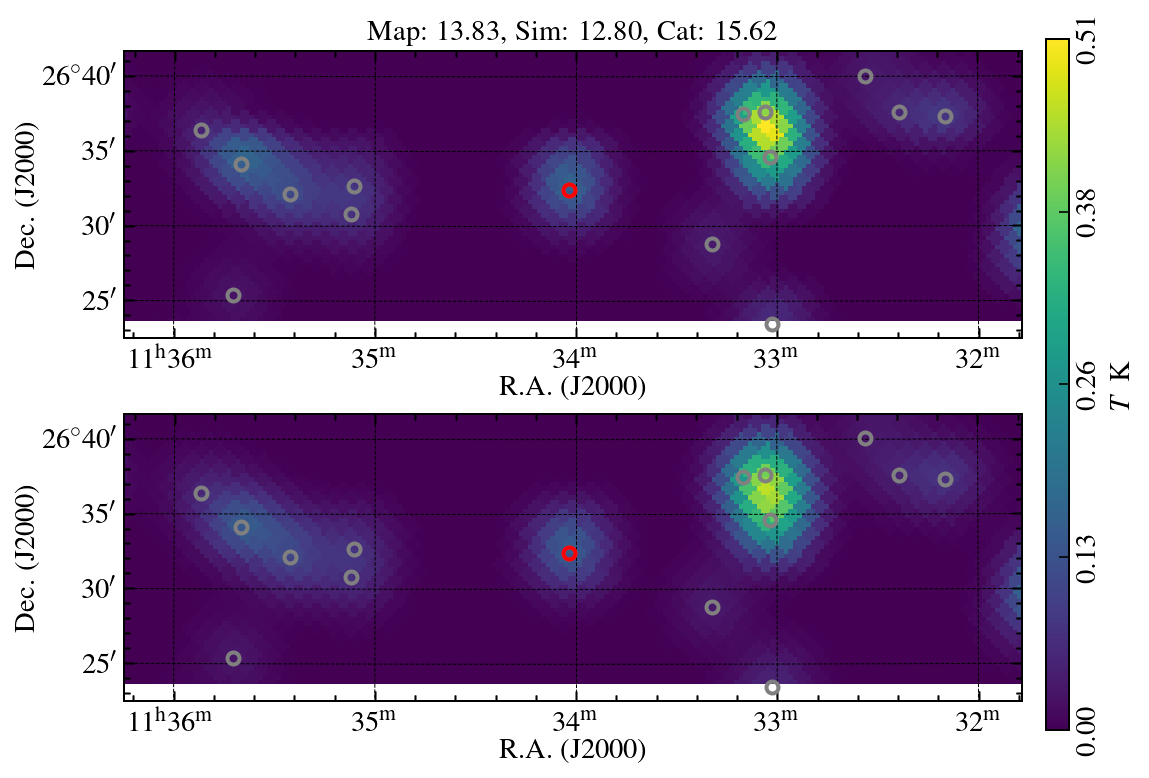

<Figure size 432x288 with 0 Axes>

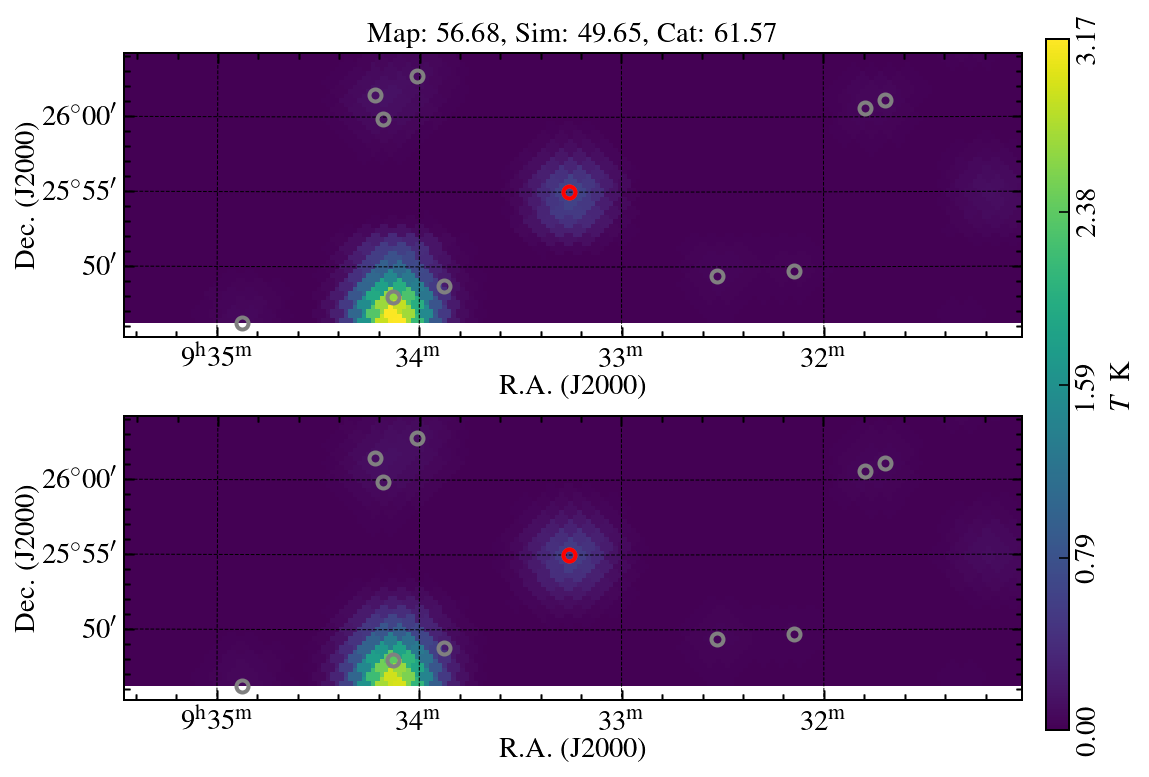

<Figure size 432x288 with 0 Axes>

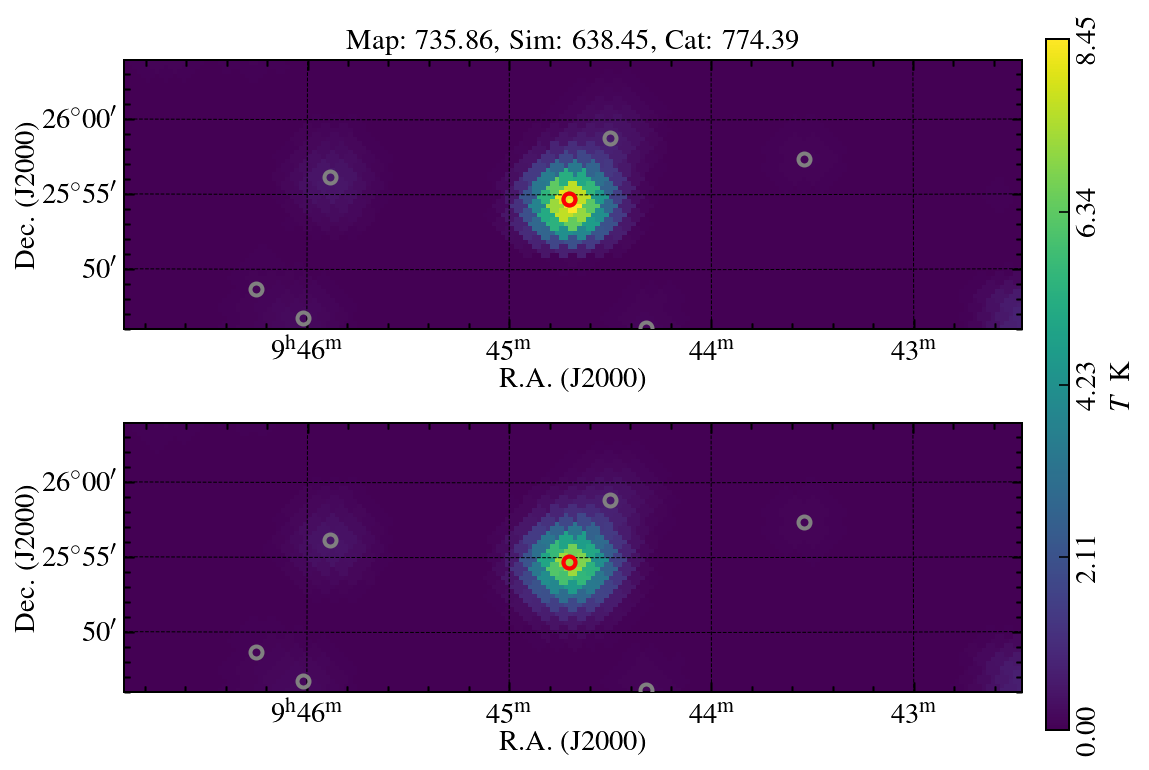

<Figure size 432x288 with 0 Axes>

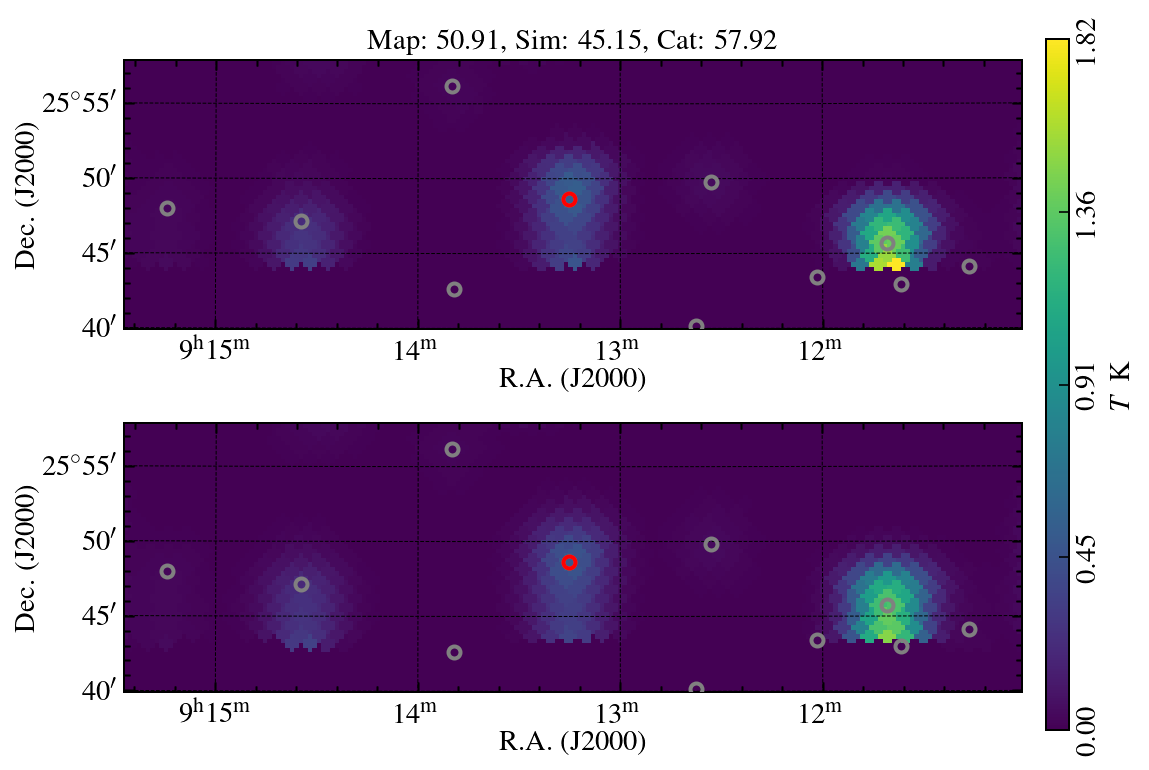

<Figure size 432x288 with 0 Axes>

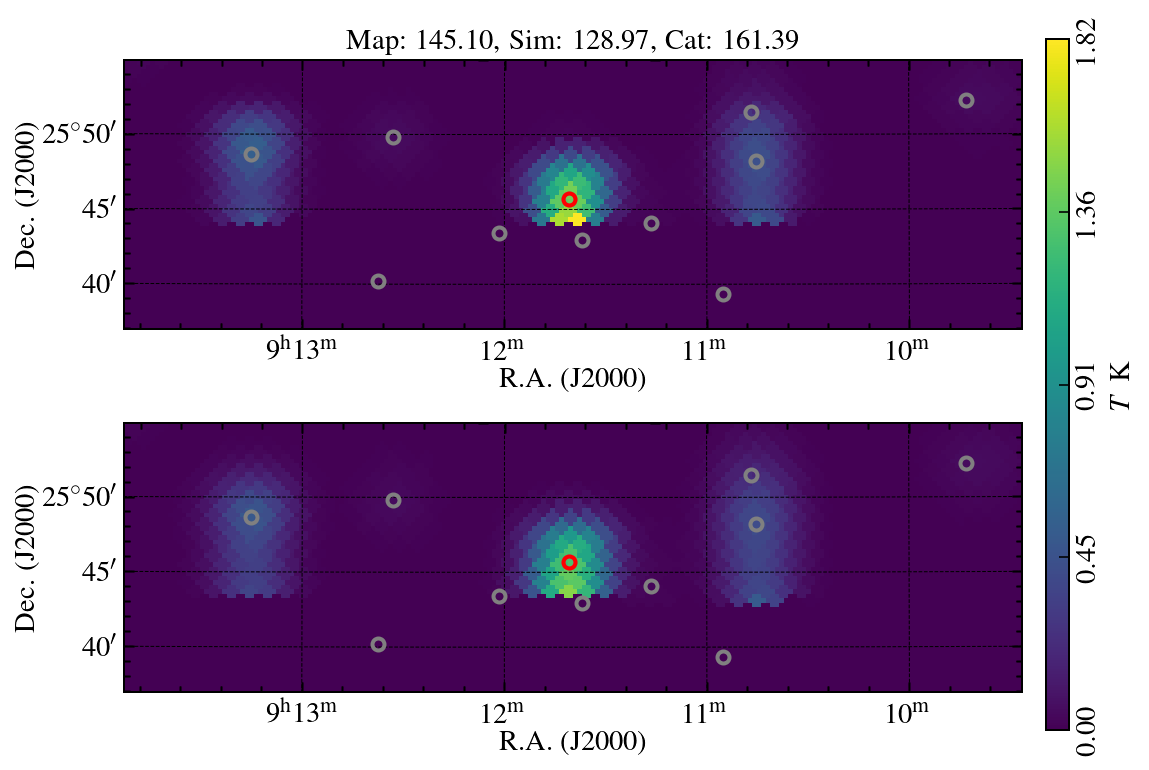

<Figure size 432x288 with 0 Axes>

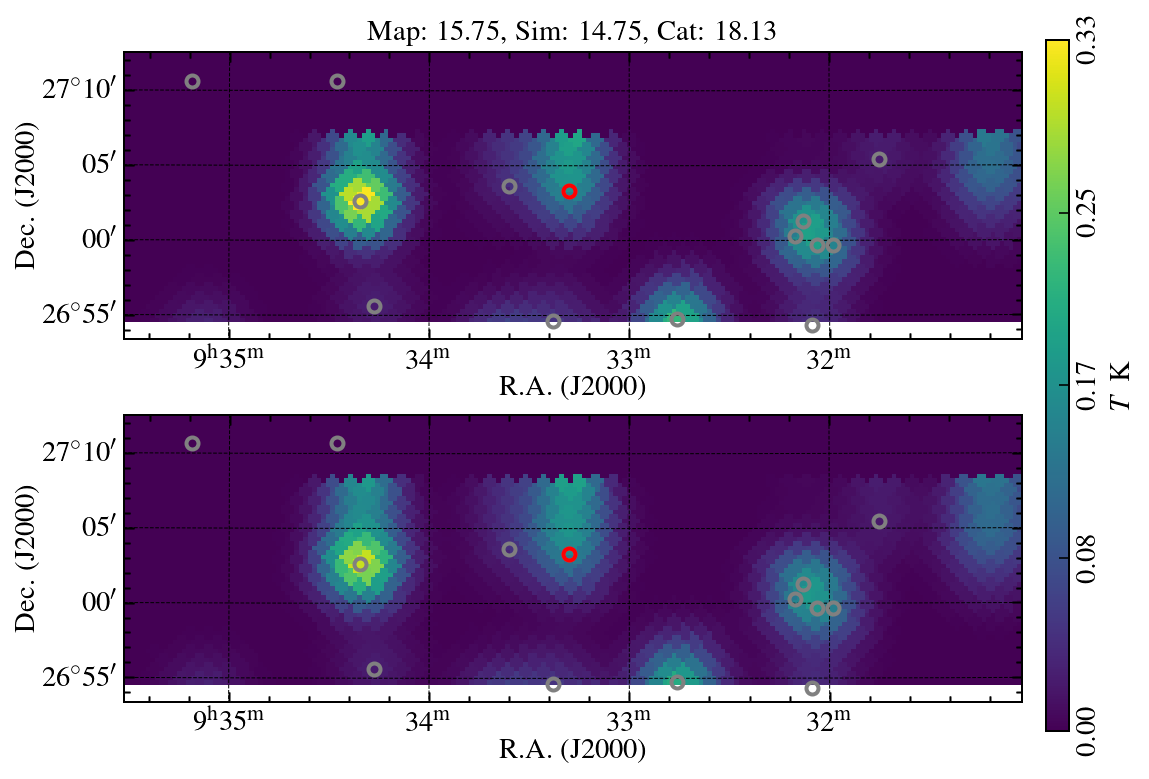

<Figure size 432x288 with 0 Axes>

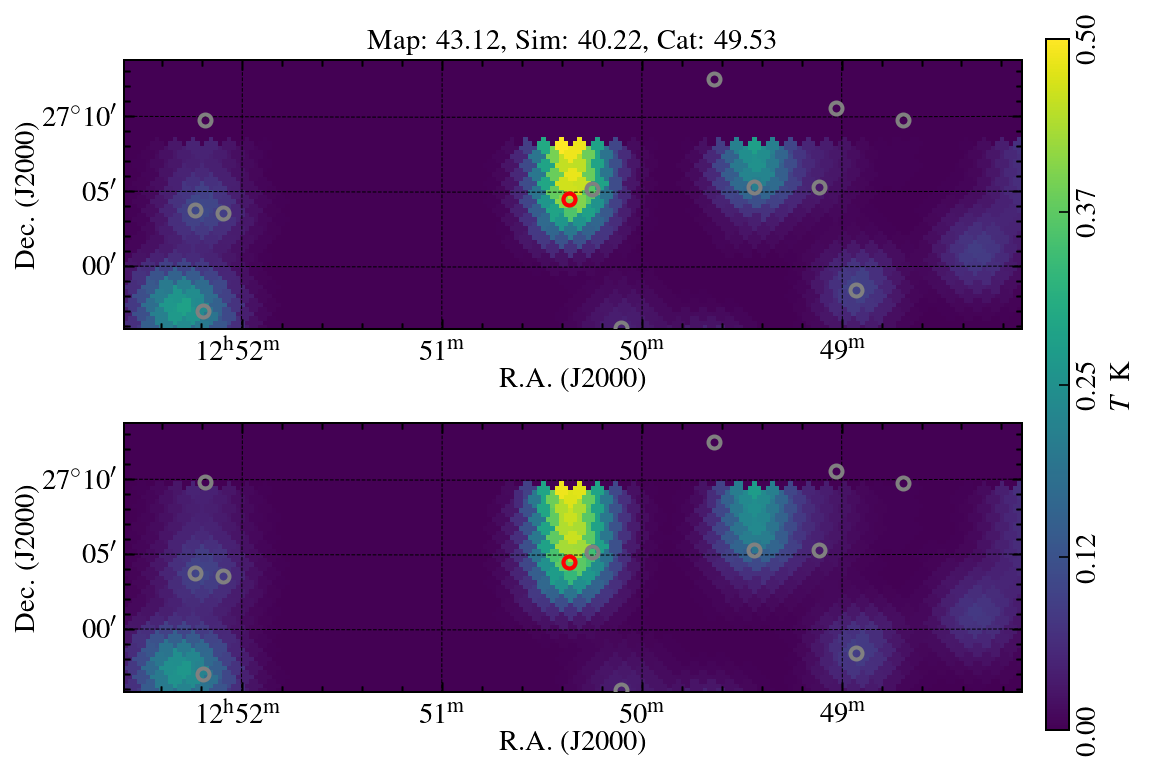

<Figure size 432x288 with 0 Axes>

In [130]:
nvss_path = [
    '/home/DATA/ycli/nvss_first/Complete_135RA140.fits',
    '/home/DATA/ycli/nvss_first/Complete_140RA145.fits', 
    '/home/DATA/ycli/nvss_first/Complete_145RA150.fits',
    '/home/DATA/ycli/nvss_first/Complete_150RA155.fits',
    '/home/DATA/ycli/nvss_first/Complete_155RA160.fits',
    '/home/DATA/ycli/nvss_first/Complete_160RA165.fits',
    '/home/DATA/ycli/nvss_first/Complete_165RA170.fits',
    '/home/DATA/ycli/nvss_first/Complete_170RA175.fits',
    '/home/DATA/ycli/nvss_first/Complete_180RA185.fits',
    '/home/DATA/ycli/nvss_first/Complete_185RA190.fits',
    '/home/DATA/ycli/nvss_first/Complete_190RA195.fits',
    '/home/DATA/ycli/nvss_first/Complete_195RA200.fits',
]



imap, pixs, nside = sim_mask_info  
imap_full = np.zeros(hp.nside2npix(nside))
imap_full[pixs] = np.ma.median( np.ma.masked_equal(imap, 0), axis=0)
imap_full = np.ma.masked_equal(imap_full, 0)
map_info = [imap_full, pixs, nside]

isim, pixs, nside = sim_info   
isim_full = np.zeros(hp.nside2npix(nside))
isim_full[pixs] = np.ma.median( np.ma.masked_equal(isim, 0), axis=0)
isim_full = np.ma.masked_equal(isim_full, 0)
sim_info = [isim_full, pixs, nside]

plot_source_map(results_sim_mask, map_info, sim_info, output_prefix='sim_mask', 
                theshold=0.2, nvss_path = nvss_path, check_cat=True)

  0%|          | 0/50 [00:00<?, ?it/s]

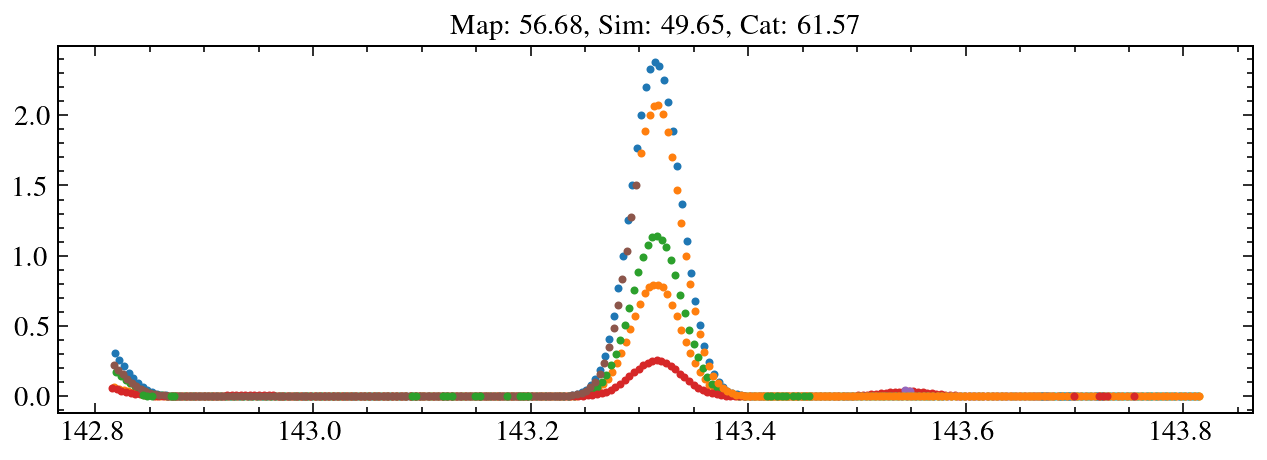

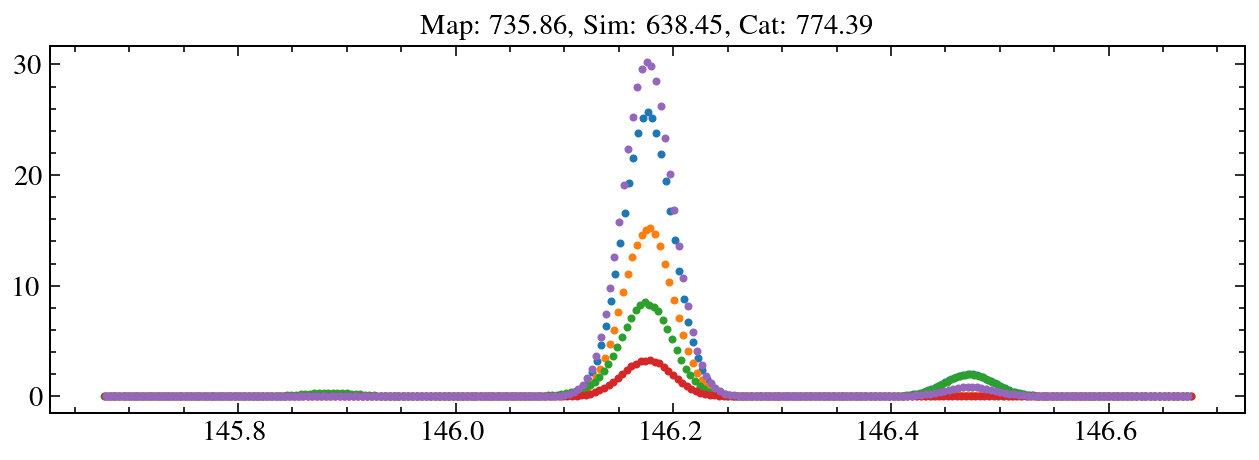

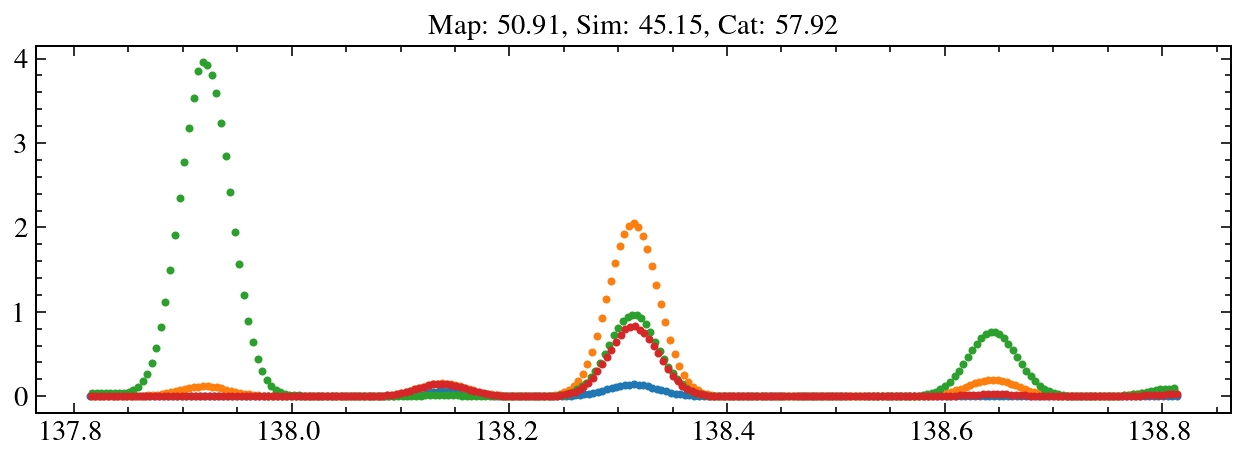

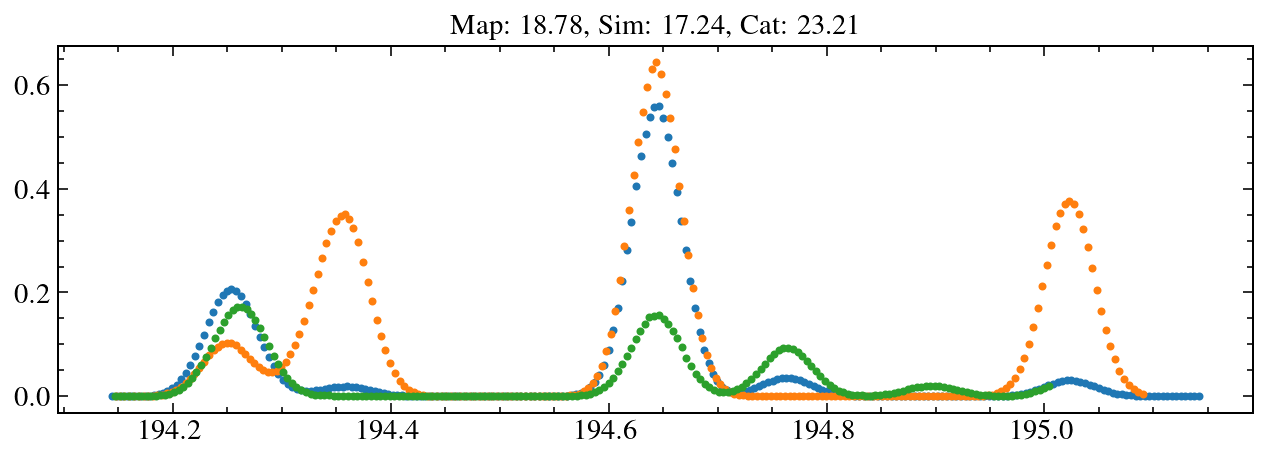

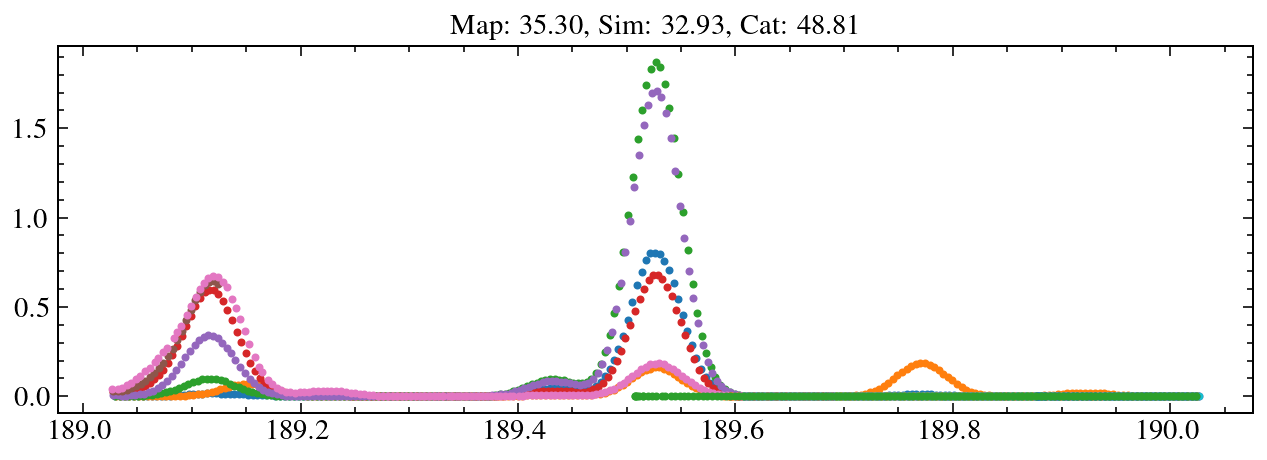

In [110]:
tod_path = '/home/ycli/data/fanalysis/sim_nvsstod_rebin/'
plot_tod(results_sim_mask, tod_path, theshold=0.2, check_cat=True)
